- Nancy Lopez
- Self-Paced

# Real Estate Market Analysis in New York

### Introduction
In this project, using advanced predictive analytics, we focus on forecasting the future trends of real estate prices across various zip codes in New York. This initiative is driven by the goal of equipping our clients with strategic insights for informed investment decisions.

### Business Problem

We are engaged by a leading real estate investment firm, known for its strategic and data-driven approach to the New York property market. The firm seeks to continue its legacy of high-return investments by identifying promising real estate opportunities. The key question is: Can we predict the future trends of property prices in New York's diverse zip codes using historical data?

### Data Overview

Our analysis utilizes an extensive dataset from Zillow, covering the period from April 1996 to April 2018. It includes variables such as RegionID, RegionName (zip codes), and median property values. This rich dataset allows for a detailed exploration of trends and patterns across New York’s varied real estate landscape.

### Objective

The primary goal is to develop a predictive model that can accurately forecast real estate prices in different New York zip codes. This model will provide crucial insights to guide investment decisions, aiming to maximize returns while minimizing risks.

### Approach

1. **Data Preparation & Cleaning**: Ensuring the dataset's accuracy and consistency for reliable analysis.
2. **Exploratory Data Analysis (EDA)**: Examining the data to understand the underlying trends and characteristics of the New York real estate market.
3. **Stationarity Testing**: Utilizing the Dickey-Fuller test to assess the stationarity of the time series data, a critical step in preparing the data for predictive modeling.
4. **Data Transformation**: Applying necessary transformations to stabilize the time series data, making it suitable for ARIMA modeling.
5. **Model Development**: Constructing ARIMA models for each zip codes, with parameters (p, d, q) meticulously chosen to optimize forecasting accuracy.
6. **Forecasting & Evaluation**: Projecting future real estate prices using the developed models and evaluating their performance through metrics such as RMSE.
7. **Risk Analysis and Cross-Validation**: Implementing cross-validation to enhance model reliability and integrating risk metrics to inform a comprehensive investment strategy.

## Load the Data
In this section, we begin by loading the Zillow dataset, which provides detailed real estate data spanning over two decades. Our primary focus is on properties in New York, due to its economic significance and diverse market. We'll handle missing data, standardize formats, and prepare the dataset for in-depth time series analysis.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the dataset
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


We can see the first few rows show columns for `RegionID`, `RegionName` (zip code), `City`, `State`, `Metro`, `CountyName`, `SizeRank`, and monthly property `values` from April 1996 to April 2018.

In [3]:
# Checking for missing values
df.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
              ... 
2017-12          0
2018-01          0
2018-02          0
2018-03          0
2018-04          0
Length: 272, dtype: int64

The `Metro` column contains some missing values. However, this column is not essential for our analysis and can be safely excluded.

#### Focusing on New York
- New York's real estate market is known to be place to live with a high price tag.
- The state's diverse range of properties, from urban apartments to suburban homes, offers a rich dataset for analysis.

In [4]:
# Creating a dataframe focused on New York data
df_ny = df[df['State'] == 'NY']
df_ny.head()


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
10,62037,11226,New York,NY,New York,Kings,11,162000.0,162300.0,162600.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
12,62087,11375,New York,NY,New York,Queens,13,252400.0,251800.0,251400.0,...,1022600,1033700,1048600,1066400,1081200,1088800,1092700,1089500,1084000,1084600
13,62045,11235,New York,NY,New York,Kings,14,190500.0,191000.0,191500.0,...,767300,777300,788800,793900,796000,799700,806600,810600,813400,816200
20,61625,10011,New York,NY,New York,New York,21,NaN,NaN,NaN,...,12137600,12112600,12036600,12050100,12016300,11946500,11978100,11849300,11563000,11478300


In [5]:
# Counting unique zip codes in New York
number_of_unique_zip_codes = df_ny['RegionName'].nunique()
print(f"Number of unique zip codes: {number_of_unique_zip_codes}")

Number of unique zip codes: 1015


There are `1015 unique zip codes` in the New York data. The dataset encompasses a wide range of zip codes, each potentially presenting unique market trends and investment opportunities.

### Pre-processing Time-series
Next we are going to transform the dataset into a format that is conducive to time series analysis.

- Convert the wide format of the data to a **long format**, which is more suitable for time series analysis.
- Ensured that the `'time'` column is in datetime format for accurate time-based calculations and plotting.

**Step 1:** Converting Data to Long Format
Time series analysis requires data in a long format where each row corresponds to a single time point for each entity (zip code, in this case). The current dataset is in a wide format, with separate columns for each month's property values. We need to restructure it to make each row represent a monthly observation for each zip code.

In [6]:
def get_datetimes(df_ny):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')


Given that the `'Metro'` column has numerous missing values and isn't essential for our analysis, we decide to drop it. This decision simplifies our dataset and focuses our analysis on the most relevant information.

In [7]:
# Dropping the 'Metro' column from the dataset
df_ny.drop('Metro', axis=1, inplace=True)

Now, we'll use the `pd.melt` function to reshape the dataset. This function takes our wide format data and 'melts' it into a long format. Each row will represent a single month's observation for a specific zip code.

In [8]:
# Melting the New York data into a long format for time series analysis
df_ny_melted = pd.melt(df_ny, id_vars=['RegionID', 'RegionName', 'City', 'State', 'CountyName', 'SizeRank'], var_name='time', value_name='value')
df_ny_melted['time'] = pd.to_datetime(df_ny_melted['time'], format='%Y-%m')

In [9]:
# Reviewing the first few rows of the transformed data
df_ny_melted.head()

,RegionID,RegionName,City,State,CountyName,SizeRank,time,value
0,61807,10467,New York,NY,Bronx,7,1996-04-01,152900.0
1,62037,11226,New York,NY,Kings,11,1996-04-01,162000.0
2,62087,11375,New York,NY,Queens,13,1996-04-01,252400.0
3,62045,11235,New York,NY,Kings,14,1996-04-01,190500.0
4,61625,10011,New York,NY,New York,21,1996-04-01,NaN


- After melting, each row in our dataset corresponds to a monthly observation for a particular zip codes, with the time column in a datetime format suitable for time series analysis. We also can see there is a `NaN` value in our data frame.

### Handling Missing Data
Effective management of missing data is crucial for accurate time series analysis.

In [10]:
# Checking for missing values
df_ny_melted.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
CountyName       0
SizeRank         0
time             0
value         3960
dtype: int64

To address missing values, we use the forward-fill method. This approach is beneficial for time series data, where the assumption is that a missing value is most accurately represented by the most recent non-missing value.

**What is Forward-Fill?**

Forward-fill is a technique where missing values are replaced by the most recent non-missing value in the series. This approach is particularly effective in time series data where each data point is typically dependent on previous values. By filling missing points with the last known value, forward-fill maintains the continuity and sequence of the data, which is essential for capturing the inherent temporal patterns in time series analysis.

In [11]:
# Forward fill to handle missing values
df_ny_melted['value'] = df_ny_melted['value'].fillna(method='ffill')

# Checking for missing values
print(df_ny_melted.isna().sum())

RegionID      0
RegionName    0
City          0
State         0
CountyName    0
SizeRank      0
time          0
value         0
dtype: int64


### Exploratory Data Analysis

Is our first step in diving into the dataset. EDA helps us uncover patterns, identifying anomalies, and understanding the driving factors of New York's real estate market. EDA is instrumental in visualizing trends and exploring price distributions, setting a foundation for more complex time series analysis.

**Visualizing Median Property Value Trends**

To observe how property values have evolved over time in different New York ZIP codes.

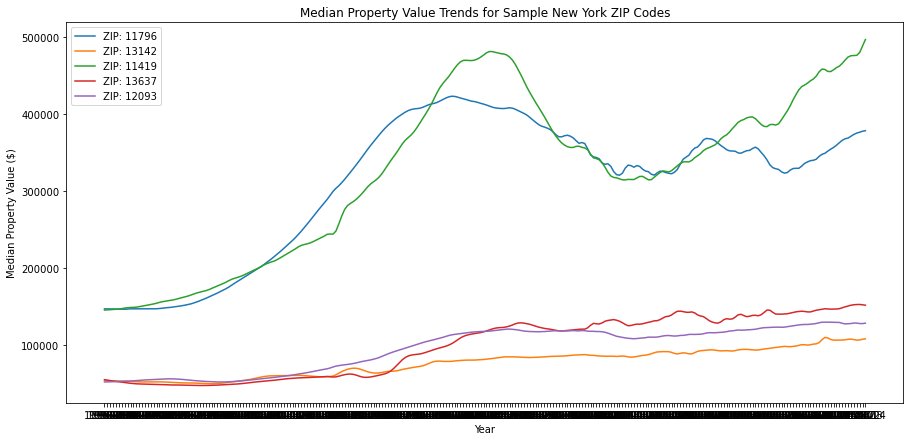

In [12]:
# Plotting the median property value trends for a few random zip codes in NY
sample_zip_codes = df_ny['RegionName'].sample(5, random_state=42).tolist()
plt.figure(figsize=(15, 7))

for zipcode in sample_zip_codes:
    sample_series = df_ny[df_ny['RegionName'] == zipcode].iloc[:, 7:].squeeze()
    plt.plot(sample_series.index, sample_series.values, label=f'ZIP: {zipcode}')

plt.title('Median Property Value Trends for Sample New York ZIP Codes')
plt.xlabel('Year')
plt.ylabel('Median Property Value ($)')
plt.legend()
plt.show()


- This visualization showcases the variability in property value trends across different zip codes, reflecting the diverse nature of New York's real estate market.
- Some zip codes we see have a steady growth, while others show fluctuations, indicating localized market dynamics.

**Analyzing Average Housing Prices**

**Next** we are going to visualize average house prices over time. In order to understand broader market trends and assess the market's response to economic events, such as the financial crisis in 2008.

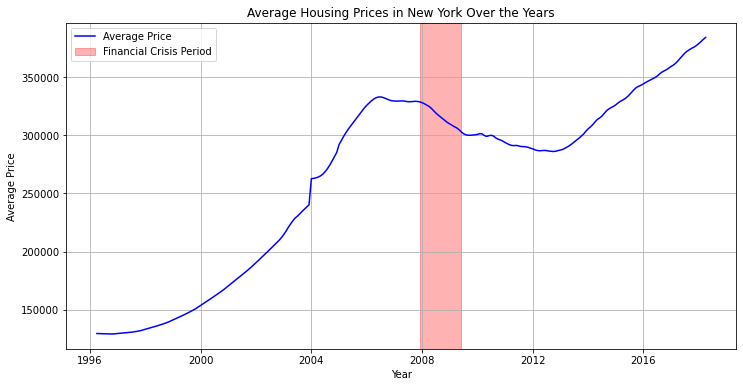

In [13]:
# Calculate the average price for each time point
avg_price = df_ny_melted.groupby('time')['value'].mean()

# Visualization highlighting the financial crisis period
plt.figure(figsize=(12, 6))
plt.plot(avg_price.index, avg_price, label='Average Price', color='blue')
plt.axvspan(pd.Timestamp('2007-12-01'), pd.Timestamp('2009-06-01'), color='red', alpha=0.3, label='Financial Crisis Period')
plt.title('Average Housing Prices in New York Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.legend()
plt.grid(True)
plt.show()

- The pre-crisis trend reveals a robust market with rising housing prices.
- The sharp decline during the financial crisis highlights the market's sensitivity to economic downturns.
- The post-crisis recovery and continued growth suggest a resilient market with strong long-term potential.

### Filtering Data Post Crisis and Identifying High-Growth Zip Codes in New York
- Focus on the last 8 years of data. This period is chosen to capture the most relevant and current market trends, ensuring that our analysis reflects the contemporary dynamics of the real estate market.

- For each zip code, calculate the percentage growth in property values over the selected period. This involves comparing the earliest and latest available property values.
#### Calculation of Growth Rates
To determine the zip codes with the most significant appreciation in property values, we calculate the percentage growth for each zip code. Growth is defined as the percentage change in property values from the beginning to the end of this 8-year period.

In [14]:
# Calculate growth rates for a recent 8-year period for each zip code
eight_years_ago = df_ny_melted['time'].max() - pd.DateOffset(years=8)

# Filter the dataset for the last 8 years
df_ny_last_8_years = df_ny_melted[df_ny_melted['time'] > eight_years_ago]

# Displaying the first few rows of the filtered dataset
df_ny_last_8_years.head()

,RegionID,RegionName,City,State,CountyName,SizeRank,time,value
171535,61807,10467,New York,NY,Bronx,7,2010-05-01,327300.0
171536,62037,11226,New York,NY,Kings,11,2010-05-01,502700.0
171537,62087,11375,New York,NY,Queens,13,2010-05-01,691300.0
171538,62045,11235,New York,NY,Kings,14,2010-05-01,501000.0
171539,61625,10011,New York,NY,New York,21,2010-05-01,6555400.0


In [15]:
# Calculate growth rates for each New York zip code
growth_rates_ny = {}
for zip_code in df_ny['RegionName'].unique():
    subset = df_ny_last_8_years[df_ny_last_8_years['RegionName'] == zip_code]
    # Ensure there are enough data points and the earliest and latest prices are not NaN
    if subset['value'].count() > 0:
        earliest_price = subset['value'].dropna().iloc[0]
        latest_price = subset['value'].dropna().iloc[-1]
        if earliest_price > 0: 
            growth_rate = ((latest_price - earliest_price) / earliest_price) * 100
            growth_rates_ny[zip_code] = growth_rate

#### Selecting the Top 20 Zip Codes
With the growth rates calculated, our next step is to identify the top 20 zip codes showing the most significant growth.

In [16]:
# Sorting zip codes by growth rate and selecting the top 20
top_20_zip_codes = sorted(growth_rates_ny.items(), key=lambda x: x[1], reverse=True)[:20]

# Displaying growth rates of the top 20 zip codes
for zip_code, growth_rate in top_20_zip_codes:
    print(f"Zip Code: {zip_code}, Growth Rate: {growth_rate:.2f}%")


Zip Code: 11101, Growth Rate: 632.68%
Zip Code: 11749, Growth Rate: 256.71%
Zip Code: 11216, Growth Rate: 234.11%
Zip Code: 11222, Growth Rate: 198.08%
Zip Code: 11211, Growth Rate: 176.61%
Zip Code: 11221, Growth Rate: 167.66%
Zip Code: 11233, Growth Rate: 151.12%
Zip Code: 11238, Growth Rate: 146.94%
Zip Code: 11217, Growth Rate: 138.80%
Zip Code: 11231, Growth Rate: 131.10%
Zip Code: 11102, Growth Rate: 124.30%
Zip Code: 11106, Growth Rate: 117.77%
Zip Code: 11218, Growth Rate: 104.57%
Zip Code: 14201, Growth Rate: 102.54%
Zip Code: 11215, Growth Rate: 98.54%
Zip Code: 11930, Growth Rate: 92.25%
Zip Code: 11226, Growth Rate: 91.61%
Zip Code: 12458, Growth Rate: 88.89%
Zip Code: 11104, Growth Rate: 83.22%
Zip Code: 11219, Growth Rate: 82.30%


- The **top 20 Zip codes** represent areas with the most significant growth in property values, suggesting a strong recovery post-crisis and a potential for future investment.

### Filtering Dataset for In-Depth Analysis:
After calculating growth rates, with our top performers identified, we concentrate our analysis on these zip codes to understand the factors contributing to their growth.

In [17]:
# Extract the top 20 zip codes from the previous analysis
top_20_zip_codes_list = [zip_code for zip_code, growth_rate in top_20_zip_codes]

# Filter dataset for detailed analysis on the top 20 zip codes
df_ny_top20 = df_ny_last_8_years[df_ny_last_8_years['RegionName'].isin(top_20_zip_codes_list)]

# Display filtered data
df_ny_top20.head()

,RegionID,RegionName,City,State,CountyName,SizeRank,time,value
171536,62037,11226,New York,NY,Kings,11,2010-05-01,502700.0
171548,62032,11221,New York,NY,Kings,71,2010-05-01,391800.0
171554,62026,11215,New York,NY,Kings,107,2010-05-01,1130200.0
171555,62022,11211,New York,NY,Kings,118,2010-05-01,587000.0
171559,62048,11238,New York,NY,Kings,157,2010-05-01,1168400.0


This step ensures that our subsequent analysis focuses on the areas with the highest potential for growth, aligning with our goal of advising clients on lucrative investment opportunities.

#### Analysis and Visualization on Top NY Zip Codes
- The focus of this step is to analyze the recovery trends post-2010. Visualize the trends and distributions in the real estate data for the top 20 zip codes in New York. 

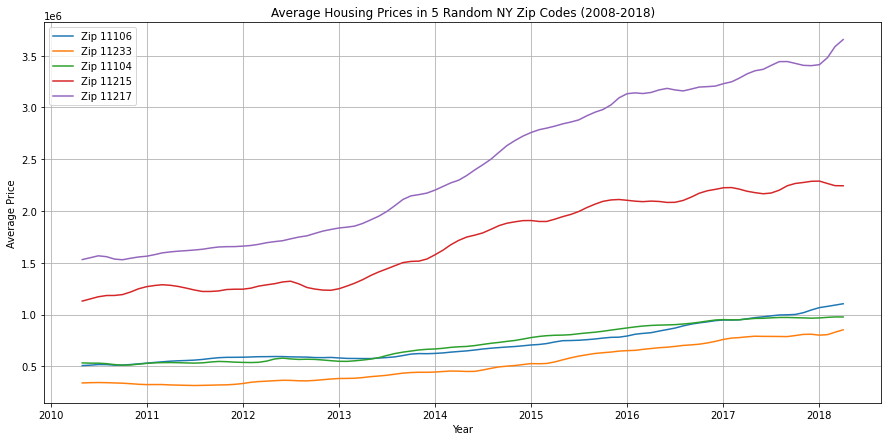

In [18]:
import random

# Data for average pricing trends
average_prices = df_ny_top20.pivot_table(index='time', columns='RegionName', values='value', aggfunc='mean')

# Randomly selecting 5 zip codes
random_zip_codes = random.sample(list(average_prices.columns), 5)

# Plotting the overall trends for the selected zip codes
plt.figure(figsize=(15, 7))
for zip_code in random_zip_codes:
    plt.plot(average_prices.index, average_prices[zip_code], label=f'Zip {zip_code}')
plt.title('Average Housing Prices in 5 Random NY Zip Codes (2008-2018)')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


**Market Resilience and Recovery**: The plot reveals a notable increase in property values in zip codes, especially post-2010, indicating a recovery from the financial crisis

## Stationarity Testing and Transformation for Time Series Analysis

Before building any forecasting models, we need to ensure that our time series data is stationary. This means the data should have a constant mean and variance over time. Non-stationary data can result in unreliable and misleading models, which is why this step is crucial.

#### Splitting the Data
We begin by dividing our dataset into two parts: a training set for building our models and a test set for evaluating their performance.

In [19]:
# Finding the split point
split_date = pd.Timestamp('2017-01-01')

# Splitting the data
train = df_ny_top20[df_ny_top20['time'] < split_date]
test = df_ny_top20[df_ny_top20['time'] >= split_date]

Now '`train'` holds data up to 2016, and `'test'` holds data from 2017 onwards.

**Dickey-Fuller Test:** We use the Augmented Dickey-Fuller test to check if the data is stationary. The null hypothesis of the test is that the time series is non-stationary. A p-value less than 0.05 typically suggests that we can reject the null hypothesis and the series is stationary. 
- If the p-value is less than a threshold 0.05, you reject the null hypothesis. The data does not have a unit root and is considered to be stationary.
- If the p-value is greater than the threshold, you fail to reject the null hypothesis. The data is presumed to have a unit root and is non-stationary.

In [20]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test
    print("Results of Dickey-Fuller Test:")
    adf_test = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(adf_test[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, value in adf_test[4].items():
        adf_output[f'critical value ({key})'] = value
    print(adf_output)
    print('-' * 50)
    return adf_output['p-value']

- We will apply this test to each time series in our dataset to identify stationary and non-stationary zip codes.

In [21]:
# Testing for stationarity and identifying stationary zip codes
stationary_zipcodes = [] 
non_stationary_zip_codes = []
for zip_code in top_20_zip_codes_list:
    series = train[train['RegionName'] == zip_code]['value']  # Make sure 'value' is the correct column name
    p_value = test_stationarity(series)
    if p_value < 0.05:
        stationary_zipcodes.append(zip_code)
    else:
        non_stationary_zip_codes.append(zip_code)

# Print the list of stationary zip codes
print("Stationary Zip Codes:", stationary_zipcodes)


Results of Dickey-Fuller Test:
Test Statistics                -0.911167
p-value                         0.784273
No. of lags used                0.000000
Number of observations used    79.000000
critical value (1%)            -3.515977
critical value (5%)            -2.898886
critical value (10%)           -2.586694
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -0.989035
p-value                         0.757243
No. of lags used                0.000000
Number of observations used    79.000000
critical value (1%)            -3.515977
critical value (5%)            -2.898886
critical value (10%)           -2.586694
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                 1.196563
p-value                         0.995962
No. of lags used                9.000000
Number of observations used    70.000000
critical value (1%)            -3.527

- All of our time series are non-stationary, which is common in real-world data, especially financial markets.
- Non-stationarity can be due to trends, cycles, or other structural changes in the data.


### Transforming Non-Stationary Data
For time series that are not stationary, we apply differencing to stabilize the mean. Differencing is a method of transforming a time series dataset to make it stationary.

- **First-Order Differencing**: We start with first-order differencing and apply the Dickey-Fuller test again to see if the series has become stationary. If the p-value is less than 0.05, we conclude that the first-order differencing has made the series stationary and append the zip code to `stationary_after_first_order_diff`.
- **Second-Order Differencing:** If first-order differencing is not enough, we proceed to second-order differencing. If the series is stationary after second-order differencing, we append the zip code to `stationary_after_second_order_diff`.

Results of Dickey-Fuller Test:
Test Statistics                -0.911167
p-value                         0.784273
No. of lags used                0.000000
Number of observations used    79.000000
critical value (1%)            -3.515977
critical value (5%)            -2.898886
critical value (10%)           -2.586694
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics               -9.114241e+00
p-value                        3.335593e-15
No. of lags used               0.000000e+00
Number of observations used    7.800000e+01
critical value (1%)           -3.517114e+00
critical value (5%)           -2.899375e+00
critical value (10%)          -2.586955e+00
dtype: float64
--------------------------------------------------
First-order differencing made the series for ZIP code 11101 stationary.


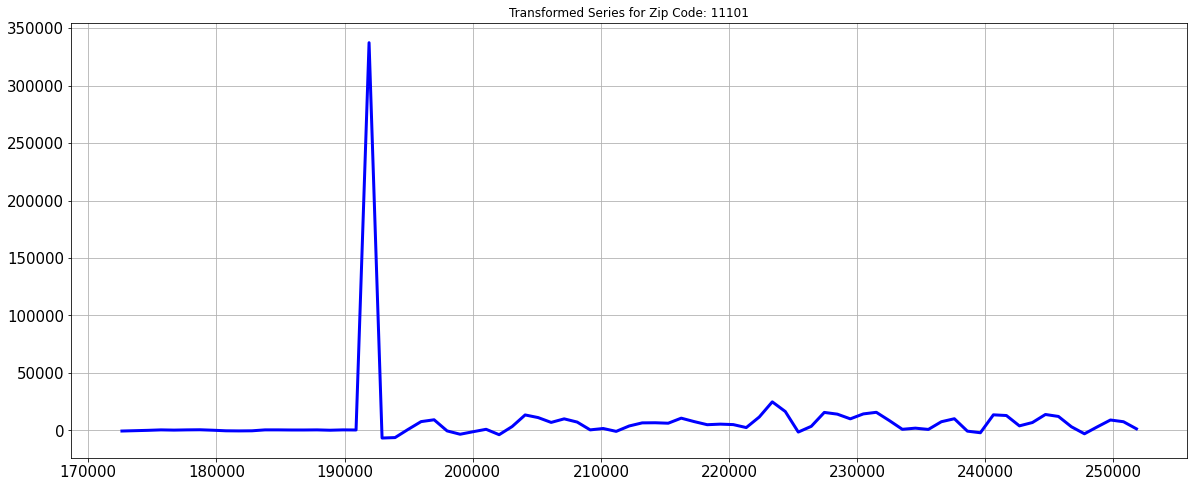

--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -0.989035
p-value                         0.757243
No. of lags used                0.000000
Number of observations used    79.000000
critical value (1%)            -3.515977
critical value (5%)            -2.898886
critical value (10%)           -2.586694
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics               -8.903344e+00
p-value                        1.155400e-14
No. of lags used               0.000000e+00
Number of observations used    7.800000e+01
critical value (1%)           -3.517114e+00
critical value (5%)           -2.899375e+00
critical value (10%)          -2.586955e+00
dtype: float64
--------------------------------------------------
First-order differencing made the series for ZIP code 11749 stationary.


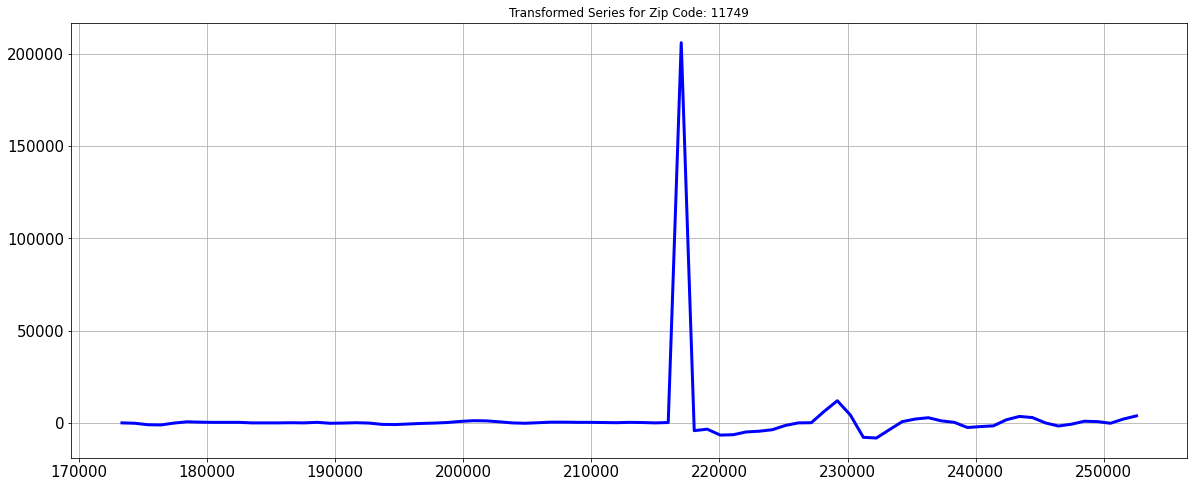

--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                 1.196563
p-value                         0.995962
No. of lags used                9.000000
Number of observations used    70.000000
critical value (1%)            -3.527426
critical value (5%)            -2.903811
critical value (10%)           -2.589320
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -1.176373
p-value                         0.683676
No. of lags used               11.000000
Number of observations used    67.000000
critical value (1%)            -3.531955
critical value (5%)            -2.905755
critical value (10%)           -2.590357
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -4.152271
p-value                         0.000793
No. of lags used               10.000000
Number of observations used

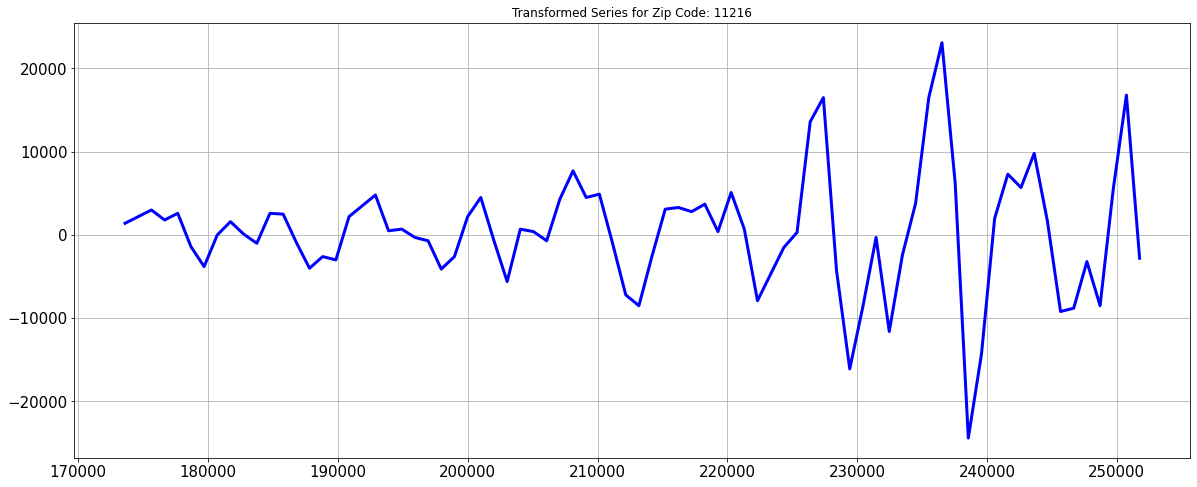

--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                 1.146801
p-value                         0.995597
No. of lags used               12.000000
Number of observations used    67.000000
critical value (1%)            -3.531955
critical value (5%)            -2.905755
critical value (10%)           -2.590357
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -1.601987
p-value                         0.482595
No. of lags used               12.000000
Number of observations used    66.000000
critical value (1%)            -3.533560
critical value (5%)            -2.906444
critical value (10%)           -2.590724
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -2.669610
p-value                         0.079446
No. of lags used               11.000000
Number of observations used

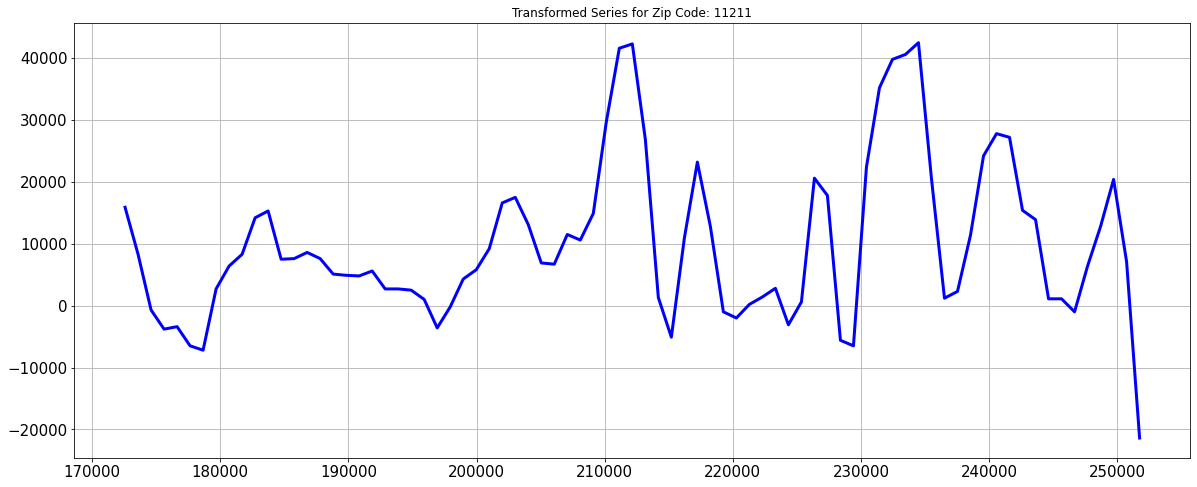

--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -0.818318
p-value                         0.813682
No. of lags used               12.000000
Number of observations used    67.000000
critical value (1%)            -3.531955
critical value (5%)            -2.905755
critical value (10%)           -2.590357
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -1.720730
p-value                         0.420464
No. of lags used               11.000000
Number of observations used    67.000000
critical value (1%)            -3.531955
critical value (5%)            -2.905755
critical value (10%)           -2.590357
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -1.974155
p-value                         0.298019
No. of lags used               10.000000
Number of observations used

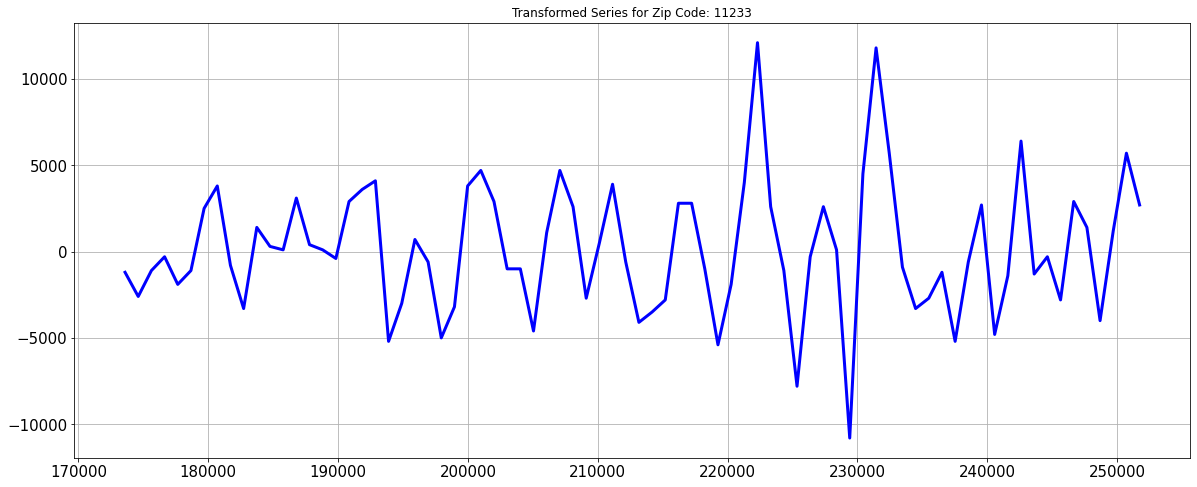

--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                 0.564820
p-value                         0.986716
No. of lags used                6.000000
Number of observations used    73.000000
critical value (1%)            -3.523284
critical value (5%)            -2.902031
critical value (10%)           -2.588371
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -2.034023
p-value                         0.271857
No. of lags used                5.000000
Number of observations used    73.000000
critical value (1%)            -3.523284
critical value (5%)            -2.902031
critical value (10%)           -2.588371
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -5.348340
p-value                         0.000004
No. of lags used                6.000000
Number of observations used

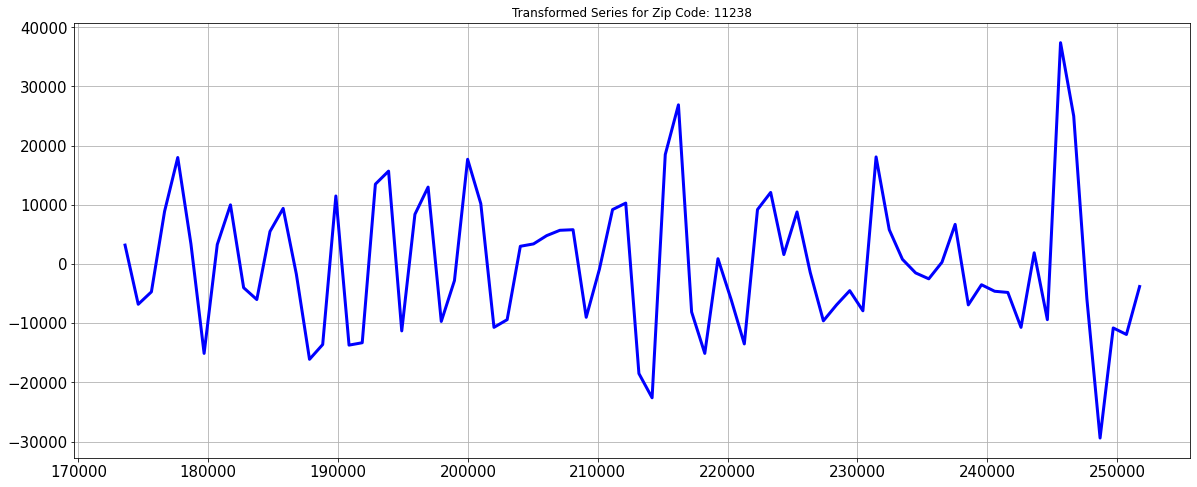

--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -1.625970
p-value                         0.469601
No. of lags used               10.000000
Number of observations used    69.000000
critical value (1%)            -3.528890
critical value (5%)            -2.904440
critical value (10%)           -2.589656
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -1.298431
p-value                         0.629890
No. of lags used                9.000000
Number of observations used    69.000000
critical value (1%)            -3.528890
critical value (5%)            -2.904440
critical value (10%)           -2.589656
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -4.670456
p-value                         0.000096
No. of lags used                8.000000
Number of observations used

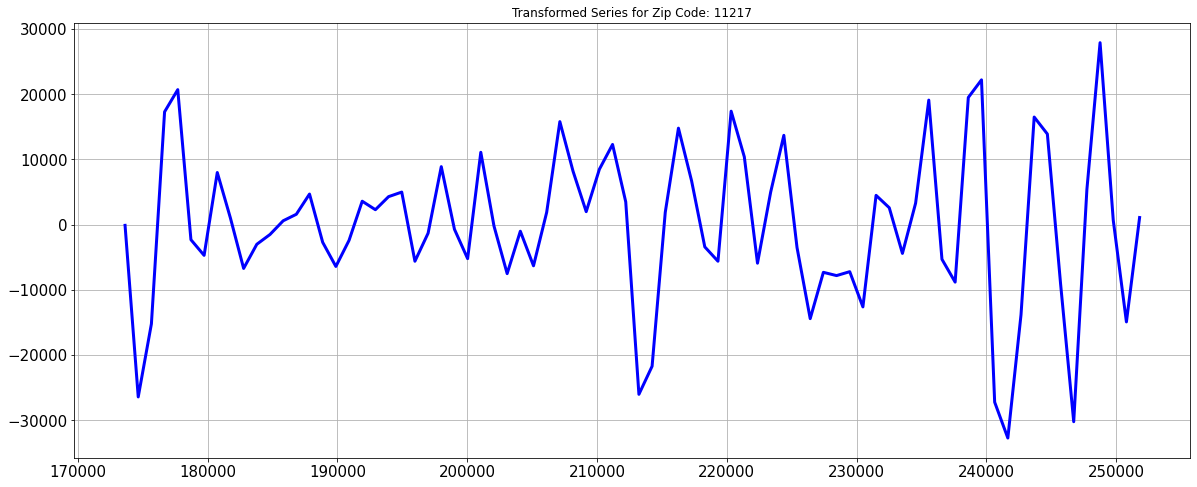

--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                 0.538730
p-value                         0.986004
No. of lags used                4.000000
Number of observations used    75.000000
critical value (1%)            -3.520713
critical value (5%)            -2.900925
critical value (10%)           -2.587781
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -4.040860
p-value                         0.001211
No. of lags used                3.000000
Number of observations used    75.000000
critical value (1%)            -3.520713
critical value (5%)            -2.900925
critical value (10%)           -2.587781
dtype: float64
--------------------------------------------------
First-order differencing made the series for ZIP code 11231 stationary.


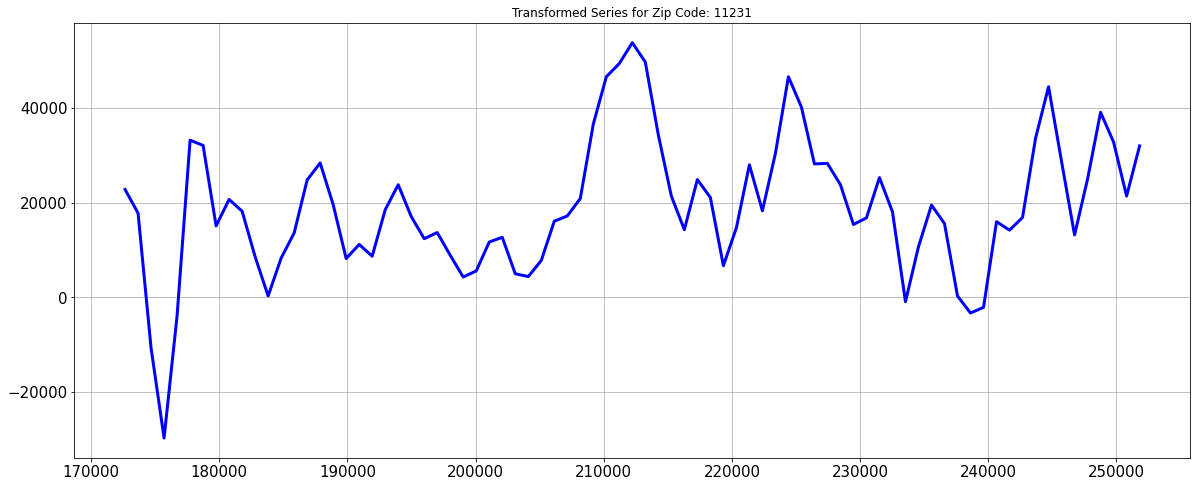

--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                 2.848254
p-value                         1.000000
No. of lags used                5.000000
Number of observations used    74.000000
critical value (1%)            -3.521980
critical value (5%)            -2.901470
critical value (10%)           -2.588072
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -0.941526
p-value                         0.773990
No. of lags used                4.000000
Number of observations used    74.000000
critical value (1%)            -3.521980
critical value (5%)            -2.901470
critical value (10%)           -2.588072
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics               -7.800555e+00
p-value                        7.513334e-12
No. of lags used               3.000000e+00
Number of observat

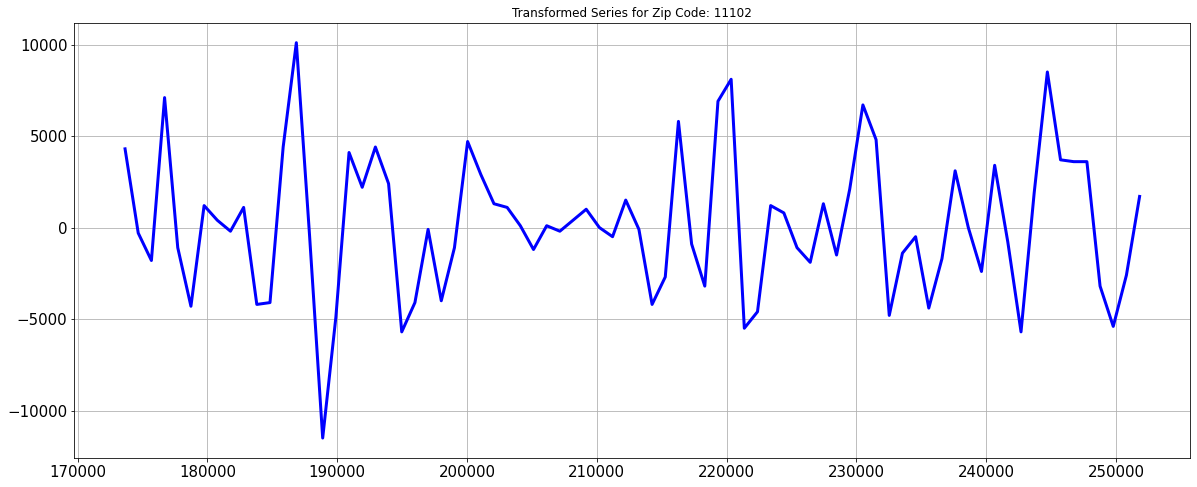

--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                 2.464442
p-value                         0.999037
No. of lags used               12.000000
Number of observations used    67.000000
critical value (1%)            -3.531955
critical value (5%)            -2.905755
critical value (10%)           -2.590357
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -0.463808
p-value                         0.898888
No. of lags used                7.000000
Number of observations used    71.000000
critical value (1%)            -3.526005
critical value (5%)            -2.903200
critical value (10%)           -2.588995
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -5.286503
p-value                         0.000006
No. of lags used                6.000000
Number of observations used

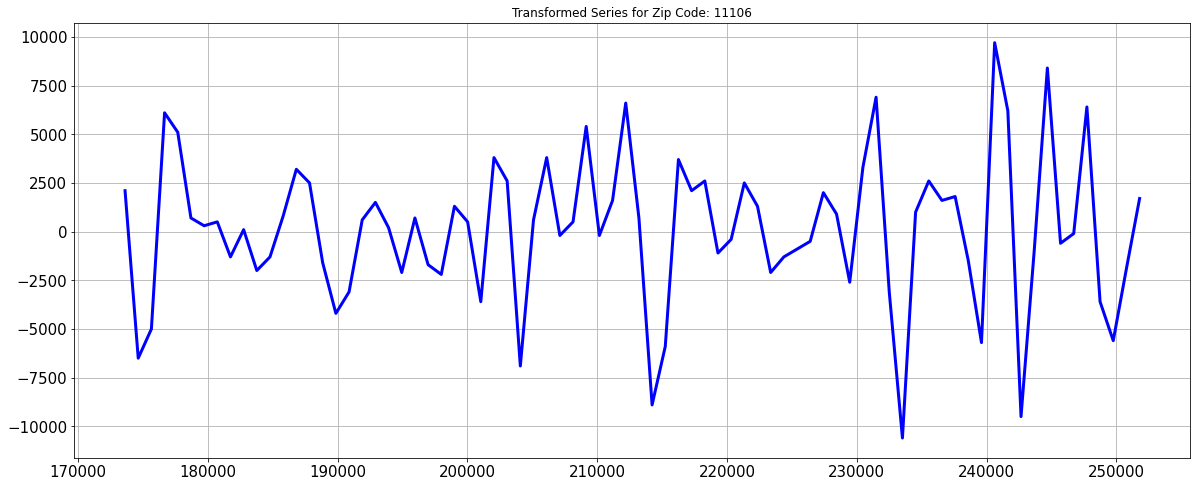

--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                 3.019572
p-value                         1.000000
No. of lags used               10.000000
Number of observations used    69.000000
critical value (1%)            -3.528890
critical value (5%)            -2.904440
critical value (10%)           -2.589656
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -2.248763
p-value                         0.189026
No. of lags used               10.000000
Number of observations used    68.000000
critical value (1%)            -3.530399
critical value (5%)            -2.905087
critical value (10%)           -2.590001
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -4.202087
p-value                         0.000654
No. of lags used               12.000000
Number of observations used

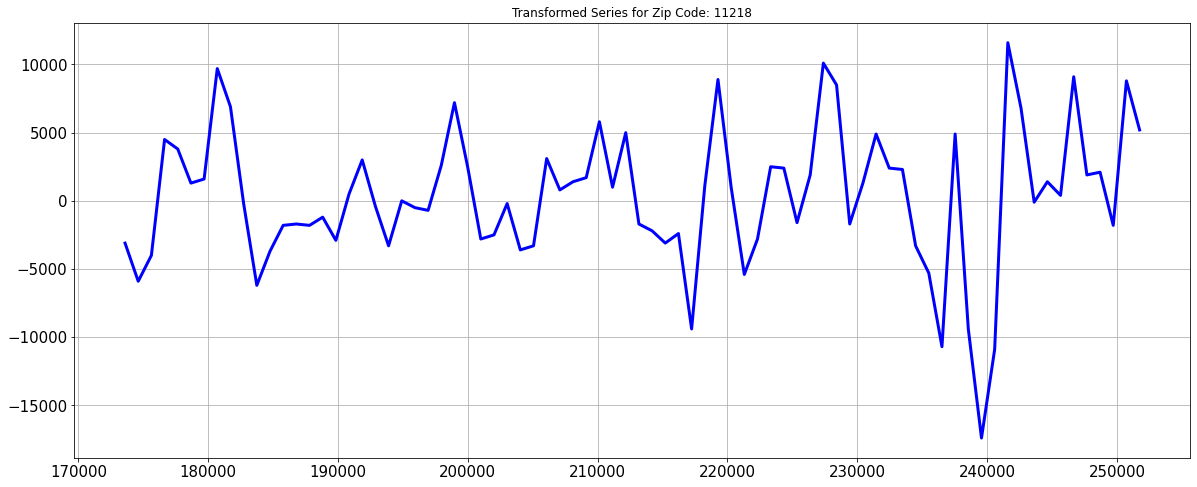

--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                 1.037049
p-value                         0.994642
No. of lags used                3.000000
Number of observations used    76.000000
critical value (1%)            -3.519481
critical value (5%)            -2.900395
critical value (10%)           -2.587498
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -4.113371
p-value                         0.000920
No. of lags used                2.000000
Number of observations used    76.000000
critical value (1%)            -3.519481
critical value (5%)            -2.900395
critical value (10%)           -2.587498
dtype: float64
--------------------------------------------------
First-order differencing made the series for ZIP code 14201 stationary.


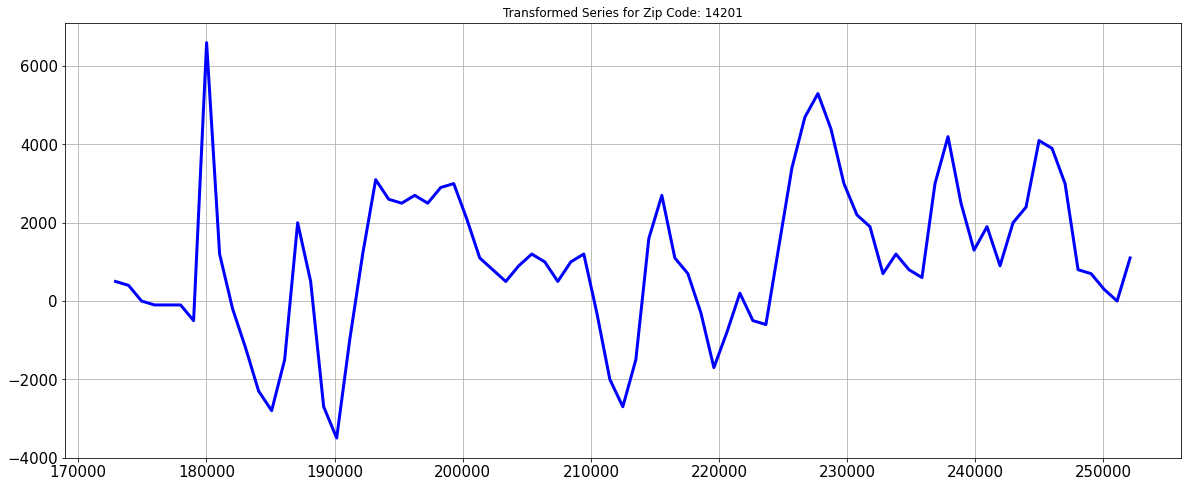

--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                 0.645396
p-value                         0.988683
No. of lags used                7.000000
Number of observations used    72.000000
critical value (1%)            -3.524624
critical value (5%)            -2.902607
critical value (10%)           -2.588679
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -2.996569
p-value                         0.035216
No. of lags used                6.000000
Number of observations used    72.000000
critical value (1%)            -3.524624
critical value (5%)            -2.902607
critical value (10%)           -2.588679
dtype: float64
--------------------------------------------------
First-order differencing made the series for ZIP code 11215 stationary.


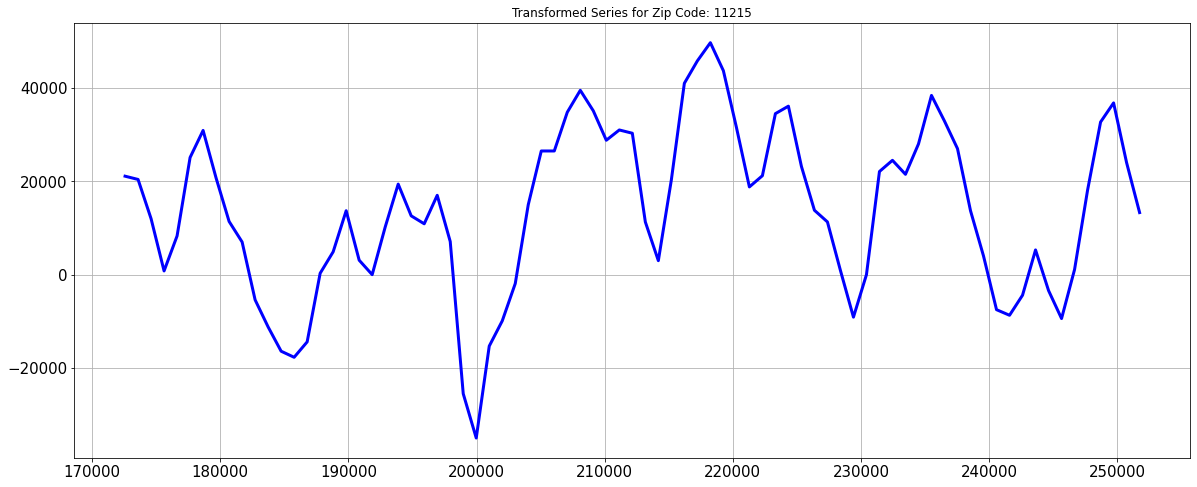

--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                 0.010224
p-value                         0.959369
No. of lags used                4.000000
Number of observations used    75.000000
critical value (1%)            -3.520713
critical value (5%)            -2.900925
critical value (10%)           -2.587781
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -3.089552
p-value                         0.027336
No. of lags used                3.000000
Number of observations used    75.000000
critical value (1%)            -3.520713
critical value (5%)            -2.900925
critical value (10%)           -2.587781
dtype: float64
--------------------------------------------------
First-order differencing made the series for ZIP code 11930 stationary.


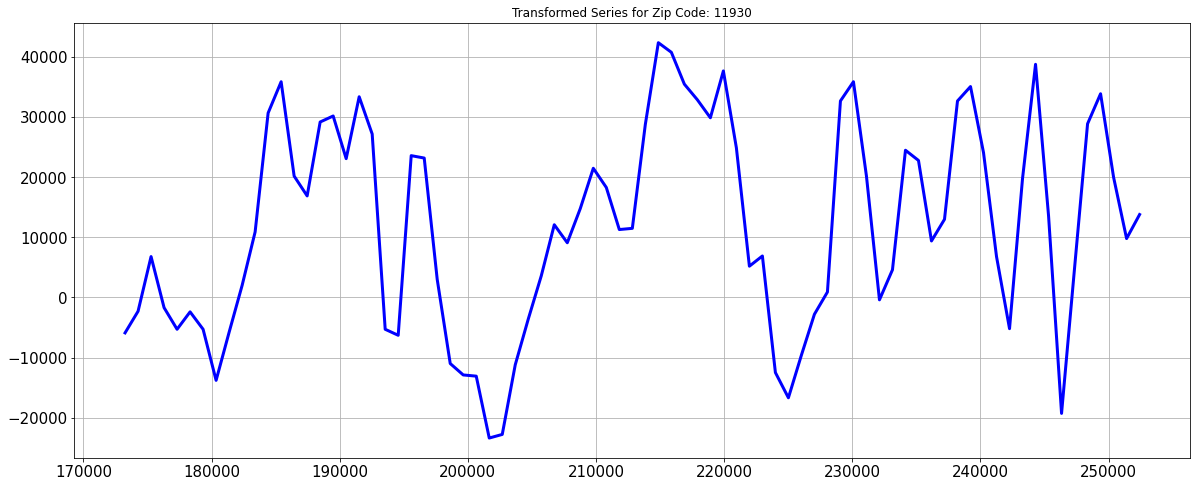

--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                 2.405124
p-value                         0.999013
No. of lags used               12.000000
Number of observations used    67.000000
critical value (1%)            -3.531955
critical value (5%)            -2.905755
critical value (10%)           -2.590357
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -2.318907
p-value                         0.165942
No. of lags used                2.000000
Number of observations used    76.000000
critical value (1%)            -3.519481
critical value (5%)            -2.900395
critical value (10%)           -2.587498
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -4.385218
p-value                         0.000315
No. of lags used                6.000000
Number of observations used

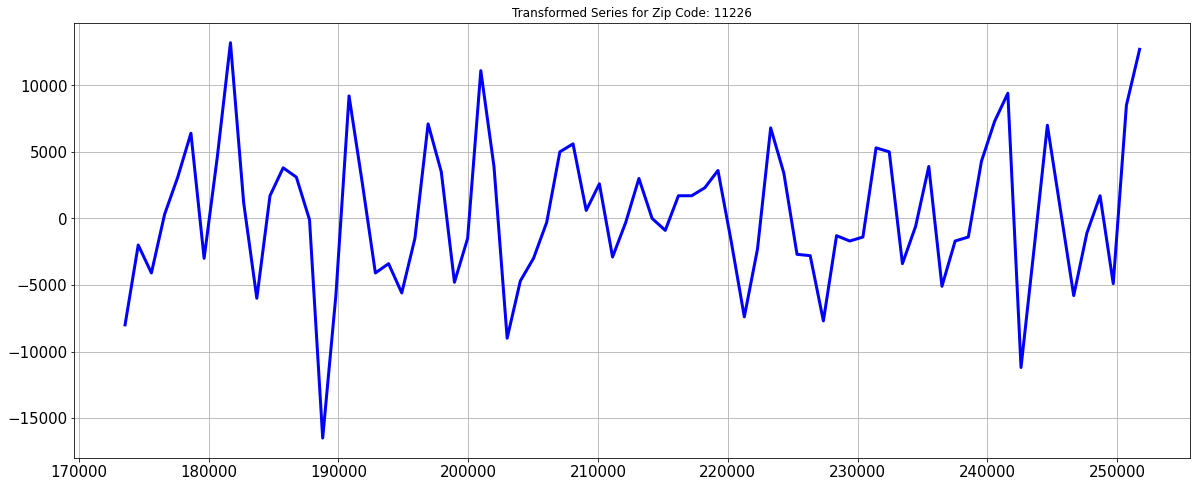

--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -0.881681
p-value                         0.793945
No. of lags used                0.000000
Number of observations used    79.000000
critical value (1%)            -3.515977
critical value (5%)            -2.898886
critical value (10%)           -2.586694
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics               -8.462958e+00
p-value                        1.549480e-13
No. of lags used               0.000000e+00
Number of observations used    7.800000e+01
critical value (1%)           -3.517114e+00
critical value (5%)           -2.899375e+00
critical value (10%)          -2.586955e+00
dtype: float64
--------------------------------------------------
First-order differencing made the series for ZIP code 12458 stationary.


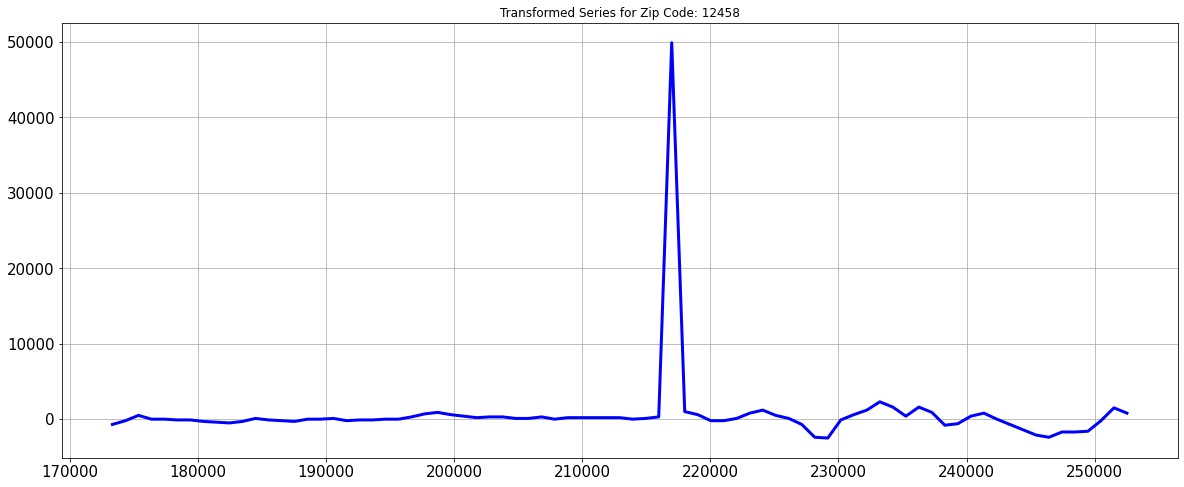

--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                 1.633583
p-value                         0.997955
No. of lags used                4.000000
Number of observations used    75.000000
critical value (1%)            -3.520713
critical value (5%)            -2.900925
critical value (10%)           -2.587781
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -4.064590
p-value                         0.001108
No. of lags used                3.000000
Number of observations used    75.000000
critical value (1%)            -3.520713
critical value (5%)            -2.900925
critical value (10%)           -2.587781
dtype: float64
--------------------------------------------------
First-order differencing made the series for ZIP code 11104 stationary.


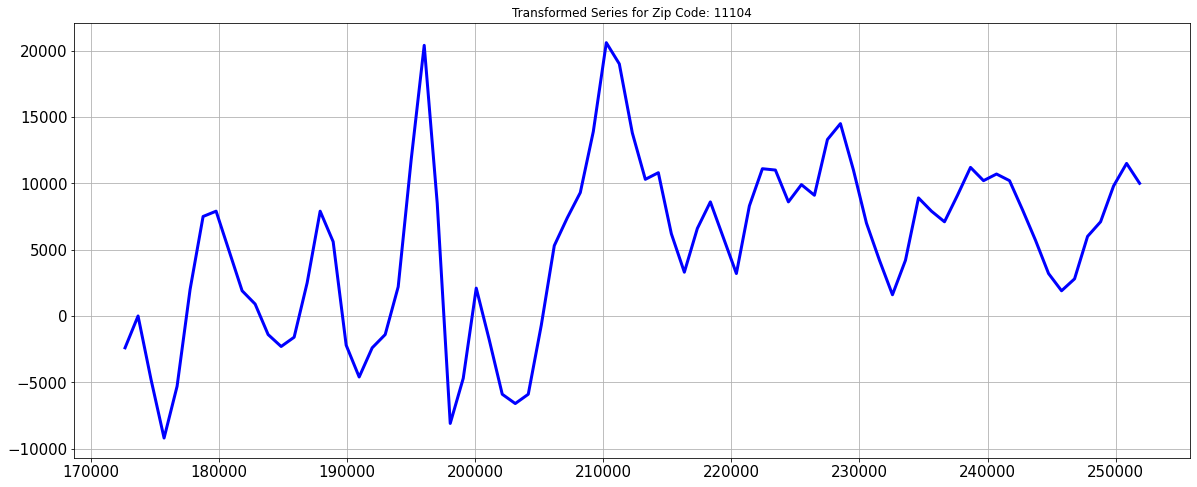

--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                 1.237199
p-value                         0.996233
No. of lags used                7.000000
Number of observations used    72.000000
critical value (1%)            -3.524624
critical value (5%)            -2.902607
critical value (10%)           -2.588679
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -3.689920
p-value                         0.004257
No. of lags used                6.000000
Number of observations used    72.000000
critical value (1%)            -3.524624
critical value (5%)            -2.902607
critical value (10%)           -2.588679
dtype: float64
--------------------------------------------------
First-order differencing made the series for ZIP code 11219 stationary.


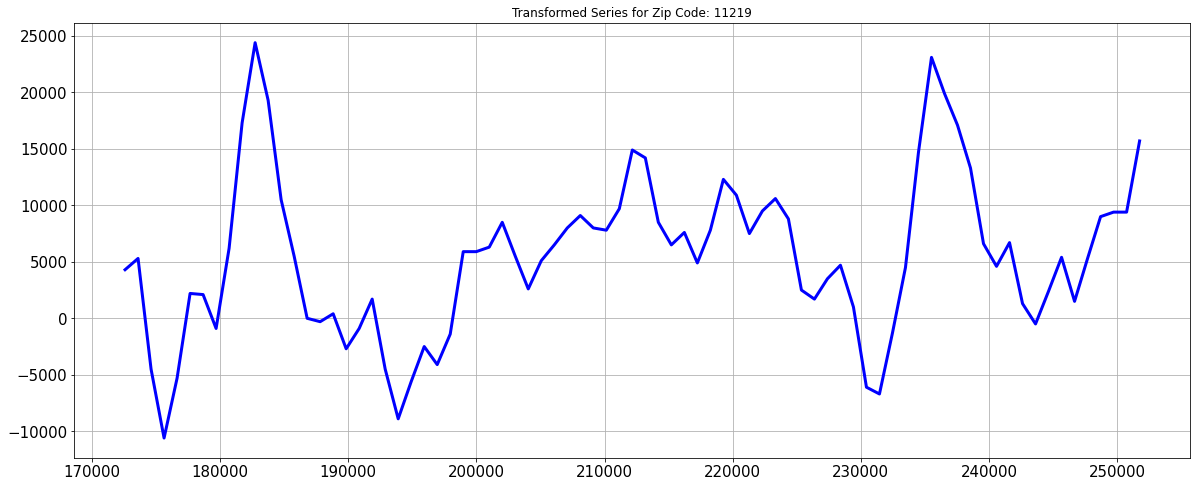

--------------------------------------------------
ZIP Codes stationary after first-order differencing: [11101, 11749, 11211, 11231, 14201, 11215, 11930, 12458, 11104, 11219]
ZIP Codes stationary after second-order differencing: [11216, 11233, 11238, 11217, 11102, 11106, 11218, 11226]


In [22]:
stationary_after_second_order_diff = []
stationary_after_first_order_diff = []

def apply_transformations(series, zip_code):
    # Ensure series has no NaN values
    series = series.dropna()

    # First-order differencing
    first_diff = series.diff().dropna()
    p_value = test_stationarity(first_diff)
    if p_value < 0.05:
        print(f"First-order differencing made the series for ZIP code {zip_code} stationary.")
        stationary_after_first_order_diff.append(zip_code)
        return first_diff

    # Second-order differencing
    second_diff = first_diff.diff().dropna()
    p_value = test_stationarity(second_diff)
    if p_value < 0.05:
        print(f"Second-order differencing made the series for ZIP code {zip_code} stationary.")
        stationary_after_second_order_diff.append(zip_code)
        return second_diff
    
    # If neither transformation made the series stationary, return None
    return None

# Apply transformations to each non-stationary zip code
non_stationary_zipcodes = []
for zip_code in non_stationary_zip_codes:
    series = train[train['RegionName'] == zip_code]['value']
    p_value = test_stationarity(series)
    if p_value >= 0.05:
        non_stationary_zipcodes.append(zip_code)
        transformed_series = apply_transformations(series, zip_code)
        if transformed_series is not None:
            plt.figure(figsize=(20, 8))
            plt.plot(transformed_series, color='blue', linewidth=3)
            plt.title(f"Transformed Series for Zip Code: {zip_code}")
            plt.grid(True)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.show()
            print('-' * 50)    

# Print the list of zip codes that became stationary after differencing
print("ZIP Codes stationary after first-order differencing:", stationary_after_first_order_diff)
print("ZIP Codes stationary after second-order differencing:", stationary_after_second_order_diff)



- After differencing, we see which zipcodes became stationary after first and second-order differencing. 

Based from `Zipcode: 11219` results after transformation.

Here's what each component of the result mean:

1. **Test Statistics (-3.689920)**: This value indicates the likelihood of the time series being non-stationary. A more negative number suggests a stationary series.

2. **p-value (0.004257)**: This measures the probability that the time series is non-stationary. A p-value below 0.05 suggests the series is likely stationary.

3. **No. of lags used (6)**: This represents the number of previous data points lags included in the test to check for patterns. 

4. **Number of observations used (72)**: The number of data points used in the test after accounting for lags.

5. **Critical Values**: These are benchmark values for comparison with the test statistic. If the test statistic is more negative than these values, it implies the time series is stationary.

Based on these results it strongly suggest that this zipcode is stationary.

- To **better** understand the effect of differencing, we can visualize the original and transformed series side by side.

Results of Dickey-Fuller Test:
Test Statistics               -9.114241e+00
p-value                        3.335593e-15
No. of lags used               0.000000e+00
Number of observations used    7.800000e+01
critical value (1%)           -3.517114e+00
critical value (5%)           -2.899375e+00
critical value (10%)          -2.586955e+00
dtype: float64
--------------------------------------------------
First-order differencing made the series for ZIP code 11101 stationary.


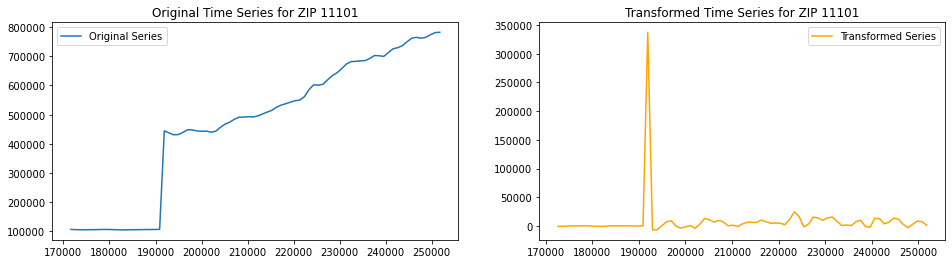

Results of Dickey-Fuller Test:
Test Statistics               -8.903344e+00
p-value                        1.155400e-14
No. of lags used               0.000000e+00
Number of observations used    7.800000e+01
critical value (1%)           -3.517114e+00
critical value (5%)           -2.899375e+00
critical value (10%)          -2.586955e+00
dtype: float64
--------------------------------------------------
First-order differencing made the series for ZIP code 11749 stationary.


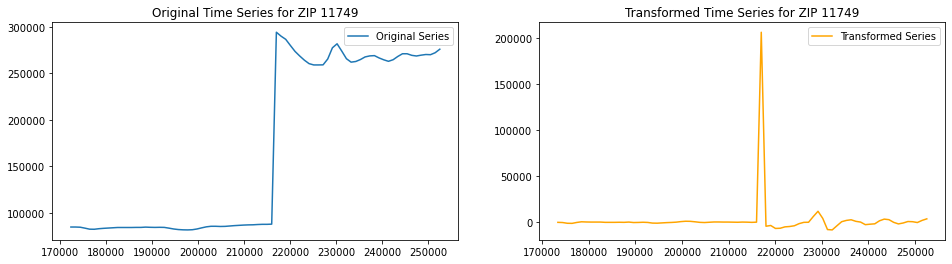

Results of Dickey-Fuller Test:
Test Statistics                -1.176373
p-value                         0.683676
No. of lags used               11.000000
Number of observations used    67.000000
critical value (1%)            -3.531955
critical value (5%)            -2.905755
critical value (10%)           -2.590357
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -4.152271
p-value                         0.000793
No. of lags used               10.000000
Number of observations used    67.000000
critical value (1%)            -3.531955
critical value (5%)            -2.905755
critical value (10%)           -2.590357
dtype: float64
--------------------------------------------------
Second-order differencing made the series for ZIP code 11216 stationary.


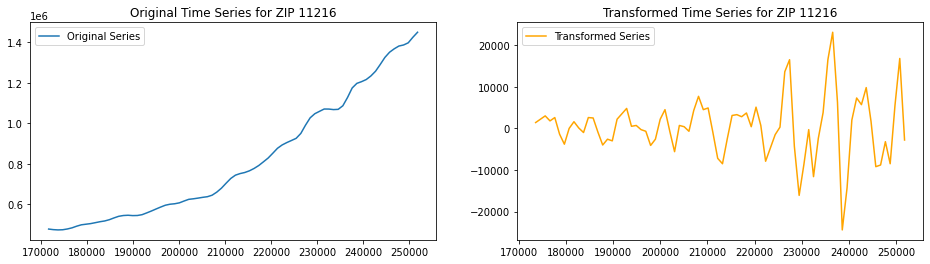

Results of Dickey-Fuller Test:
Test Statistics                -1.601987
p-value                         0.482595
No. of lags used               12.000000
Number of observations used    66.000000
critical value (1%)            -3.533560
critical value (5%)            -2.906444
critical value (10%)           -2.590724
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -2.669610
p-value                         0.079446
No. of lags used               11.000000
Number of observations used    66.000000
critical value (1%)            -3.533560
critical value (5%)            -2.906444
critical value (10%)           -2.590724
dtype: float64
--------------------------------------------------
No suitable transformation found for ZIP code 11222
Results of Dickey-Fuller Test:
Test Statistics                -3.150324
p-value                         0.023046
No. of lags used                9.000000
Number of observations use

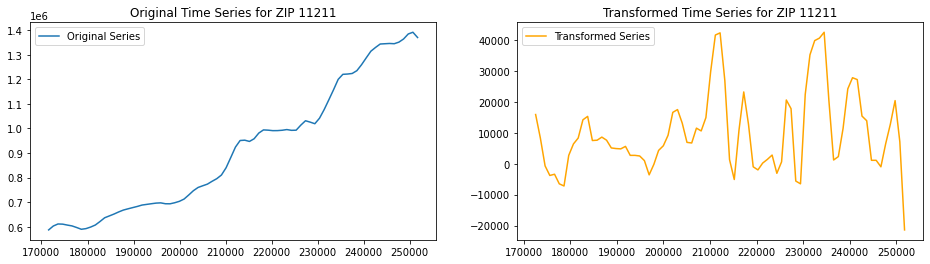

Results of Dickey-Fuller Test:
Test Statistics                -1.720730
p-value                         0.420464
No. of lags used               11.000000
Number of observations used    67.000000
critical value (1%)            -3.531955
critical value (5%)            -2.905755
critical value (10%)           -2.590357
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -1.974155
p-value                         0.298019
No. of lags used               10.000000
Number of observations used    67.000000
critical value (1%)            -3.531955
critical value (5%)            -2.905755
critical value (10%)           -2.590357
dtype: float64
--------------------------------------------------
No suitable transformation found for ZIP code 11221
Results of Dickey-Fuller Test:
Test Statistics                -1.883595
p-value                         0.339817
No. of lags used               12.000000
Number of observations use

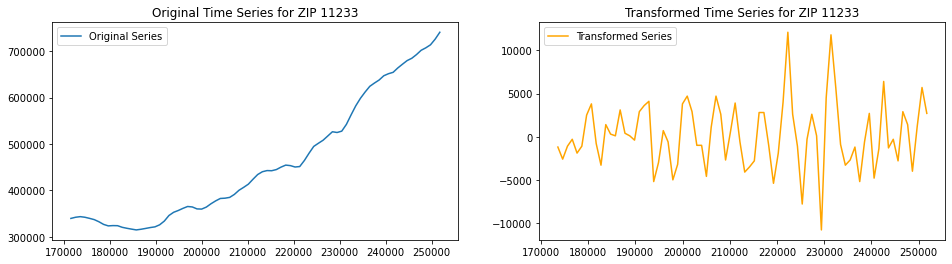

Results of Dickey-Fuller Test:
Test Statistics                -2.034023
p-value                         0.271857
No. of lags used                5.000000
Number of observations used    73.000000
critical value (1%)            -3.523284
critical value (5%)            -2.902031
critical value (10%)           -2.588371
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -5.348340
p-value                         0.000004
No. of lags used                6.000000
Number of observations used    71.000000
critical value (1%)            -3.526005
critical value (5%)            -2.903200
critical value (10%)           -2.588995
dtype: float64
--------------------------------------------------
Second-order differencing made the series for ZIP code 11238 stationary.


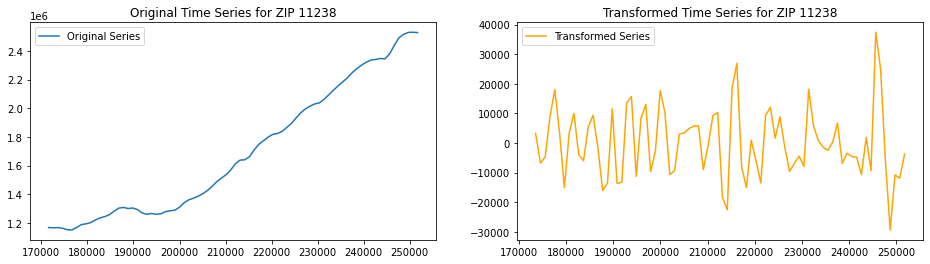

Results of Dickey-Fuller Test:
Test Statistics                -1.298431
p-value                         0.629890
No. of lags used                9.000000
Number of observations used    69.000000
critical value (1%)            -3.528890
critical value (5%)            -2.904440
critical value (10%)           -2.589656
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -4.670456
p-value                         0.000096
No. of lags used                8.000000
Number of observations used    69.000000
critical value (1%)            -3.528890
critical value (5%)            -2.904440
critical value (10%)           -2.589656
dtype: float64
--------------------------------------------------
Second-order differencing made the series for ZIP code 11217 stationary.


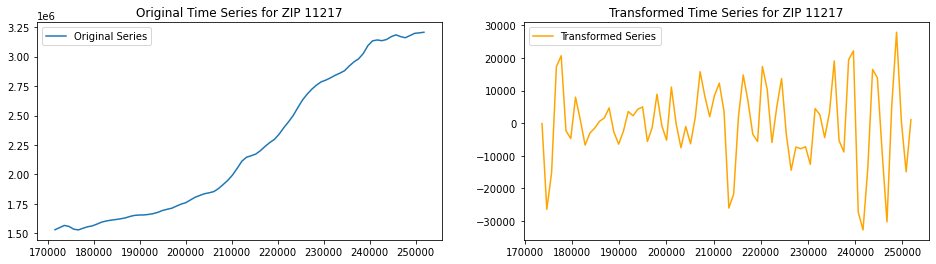

Results of Dickey-Fuller Test:
Test Statistics                -4.040860
p-value                         0.001211
No. of lags used                3.000000
Number of observations used    75.000000
critical value (1%)            -3.520713
critical value (5%)            -2.900925
critical value (10%)           -2.587781
dtype: float64
--------------------------------------------------
First-order differencing made the series for ZIP code 11231 stationary.


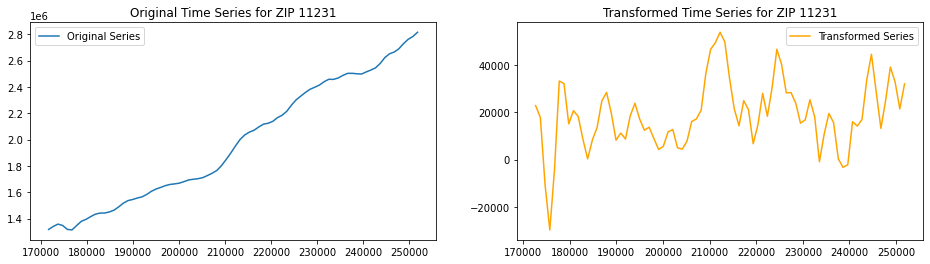

Results of Dickey-Fuller Test:
Test Statistics                -0.941526
p-value                         0.773990
No. of lags used                4.000000
Number of observations used    74.000000
critical value (1%)            -3.521980
critical value (5%)            -2.901470
critical value (10%)           -2.588072
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics               -7.800555e+00
p-value                        7.513334e-12
No. of lags used               3.000000e+00
Number of observations used    7.400000e+01
critical value (1%)           -3.521980e+00
critical value (5%)           -2.901470e+00
critical value (10%)          -2.588072e+00
dtype: float64
--------------------------------------------------
Second-order differencing made the series for ZIP code 11102 stationary.


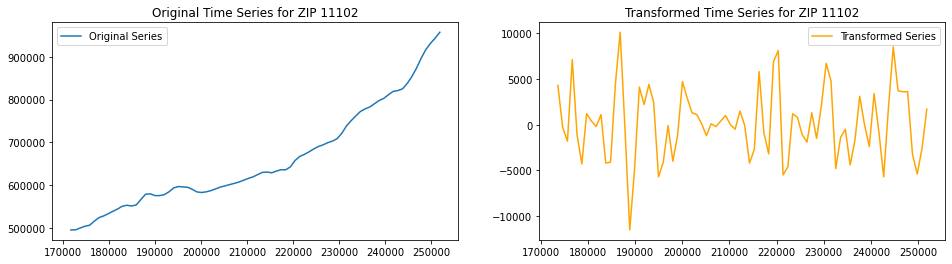

Results of Dickey-Fuller Test:
Test Statistics                -0.463808
p-value                         0.898888
No. of lags used                7.000000
Number of observations used    71.000000
critical value (1%)            -3.526005
critical value (5%)            -2.903200
critical value (10%)           -2.588995
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -5.286503
p-value                         0.000006
No. of lags used                6.000000
Number of observations used    71.000000
critical value (1%)            -3.526005
critical value (5%)            -2.903200
critical value (10%)           -2.588995
dtype: float64
--------------------------------------------------
Second-order differencing made the series for ZIP code 11106 stationary.


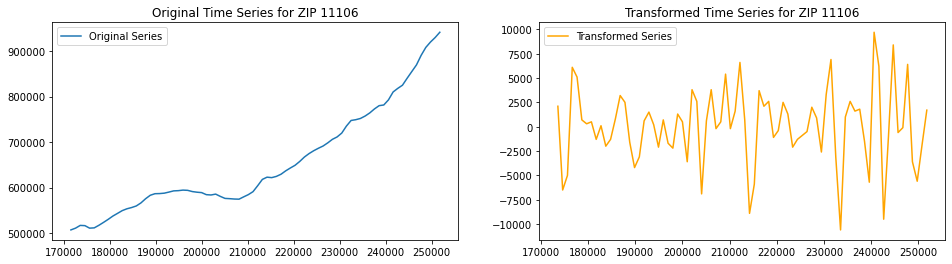

Results of Dickey-Fuller Test:
Test Statistics                -2.248763
p-value                         0.189026
No. of lags used               10.000000
Number of observations used    68.000000
critical value (1%)            -3.530399
critical value (5%)            -2.905087
critical value (10%)           -2.590001
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -4.202087
p-value                         0.000654
No. of lags used               12.000000
Number of observations used    65.000000
critical value (1%)            -3.535217
critical value (5%)            -2.907154
critical value (10%)           -2.591103
dtype: float64
--------------------------------------------------
Second-order differencing made the series for ZIP code 11218 stationary.


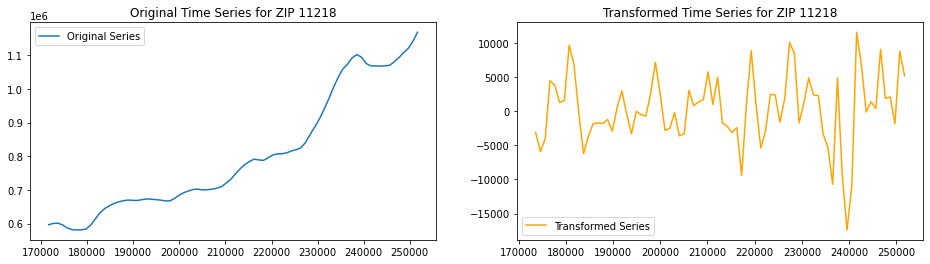

Results of Dickey-Fuller Test:
Test Statistics                -4.113371
p-value                         0.000920
No. of lags used                2.000000
Number of observations used    76.000000
critical value (1%)            -3.519481
critical value (5%)            -2.900395
critical value (10%)           -2.587498
dtype: float64
--------------------------------------------------
First-order differencing made the series for ZIP code 14201 stationary.


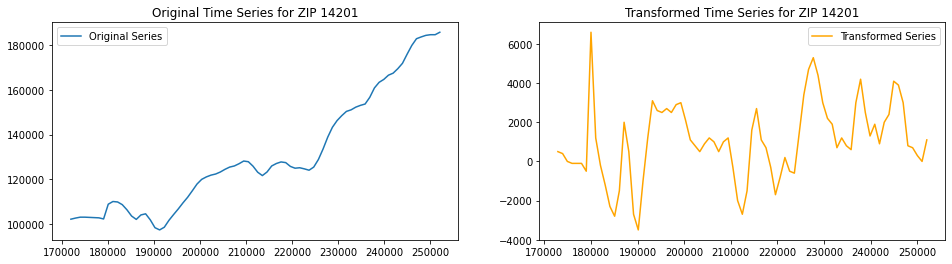

Results of Dickey-Fuller Test:
Test Statistics                -2.996569
p-value                         0.035216
No. of lags used                6.000000
Number of observations used    72.000000
critical value (1%)            -3.524624
critical value (5%)            -2.902607
critical value (10%)           -2.588679
dtype: float64
--------------------------------------------------
First-order differencing made the series for ZIP code 11215 stationary.


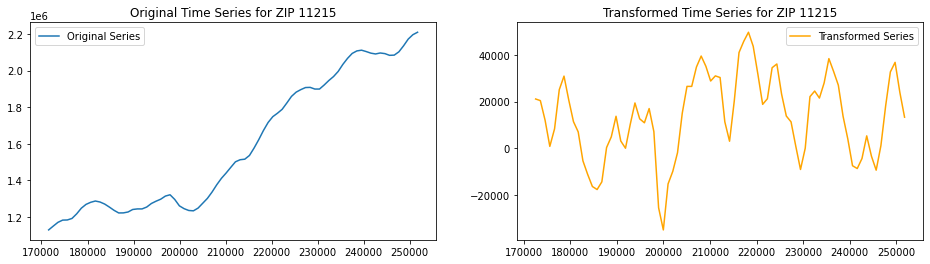

Results of Dickey-Fuller Test:
Test Statistics                -3.089552
p-value                         0.027336
No. of lags used                3.000000
Number of observations used    75.000000
critical value (1%)            -3.520713
critical value (5%)            -2.900925
critical value (10%)           -2.587781
dtype: float64
--------------------------------------------------
First-order differencing made the series for ZIP code 11930 stationary.


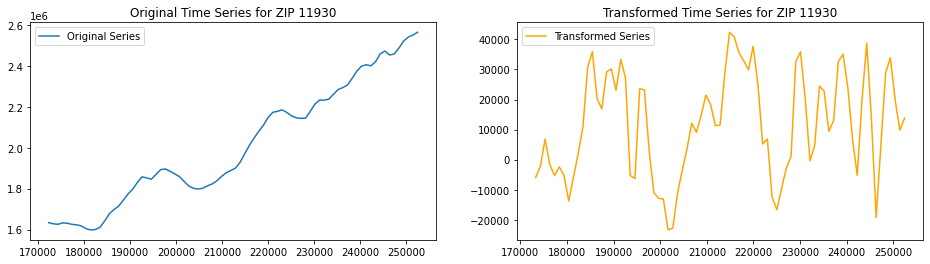

Results of Dickey-Fuller Test:
Test Statistics                -2.318907
p-value                         0.165942
No. of lags used                2.000000
Number of observations used    76.000000
critical value (1%)            -3.519481
critical value (5%)            -2.900395
critical value (10%)           -2.587498
dtype: float64
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistics                -4.385218
p-value                         0.000315
No. of lags used                6.000000
Number of observations used    71.000000
critical value (1%)            -3.526005
critical value (5%)            -2.903200
critical value (10%)           -2.588995
dtype: float64
--------------------------------------------------
Second-order differencing made the series for ZIP code 11226 stationary.


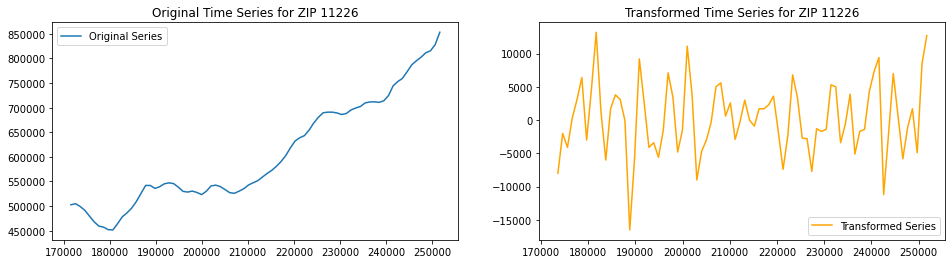

Results of Dickey-Fuller Test:
Test Statistics               -8.462958e+00
p-value                        1.549480e-13
No. of lags used               0.000000e+00
Number of observations used    7.800000e+01
critical value (1%)           -3.517114e+00
critical value (5%)           -2.899375e+00
critical value (10%)          -2.586955e+00
dtype: float64
--------------------------------------------------
First-order differencing made the series for ZIP code 12458 stationary.


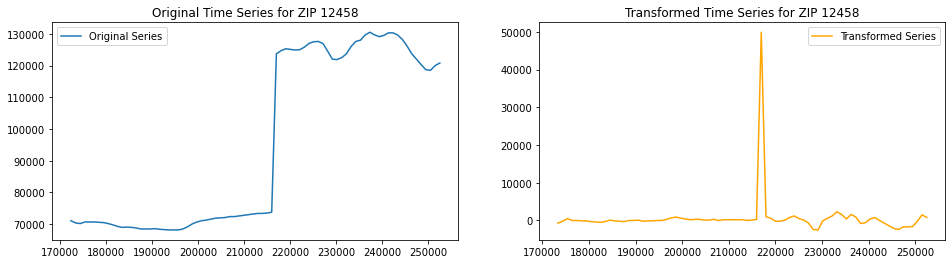

Results of Dickey-Fuller Test:
Test Statistics                -4.064590
p-value                         0.001108
No. of lags used                3.000000
Number of observations used    75.000000
critical value (1%)            -3.520713
critical value (5%)            -2.900925
critical value (10%)           -2.587781
dtype: float64
--------------------------------------------------
First-order differencing made the series for ZIP code 11104 stationary.


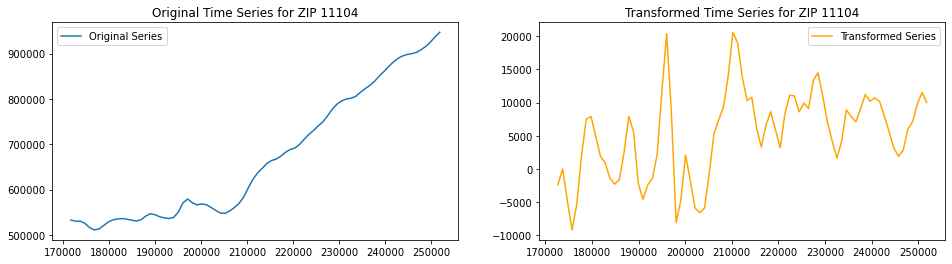

Results of Dickey-Fuller Test:
Test Statistics                -3.689920
p-value                         0.004257
No. of lags used                6.000000
Number of observations used    72.000000
critical value (1%)            -3.524624
critical value (5%)            -2.902607
critical value (10%)           -2.588679
dtype: float64
--------------------------------------------------
First-order differencing made the series for ZIP code 11219 stationary.


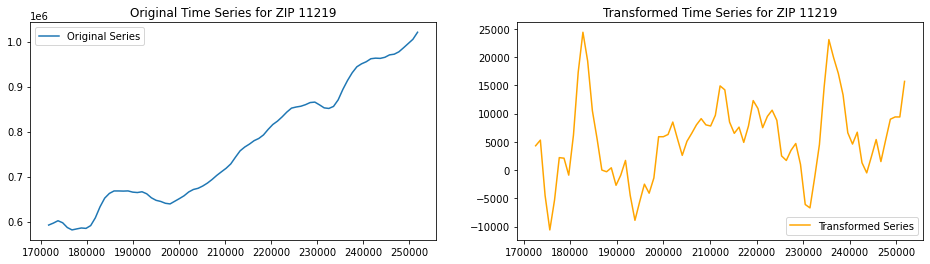

In [23]:
# Visualization of original and transformed
for zip_code in non_stationary_zip_codes:
    series = train[train['RegionName'] == zip_code]['value']
    transformed_series = apply_transformations(series, zip_code)
    if transformed_series is not None:
        fig, ax = plt.subplots(1, 2, figsize=(16, 4))
        ax[0].plot(series.index, series, label='Original Series')
        ax[0].set_title(f"Original Time Series for ZIP {zip_code}")
        ax[0].legend()

        ax[1].plot(transformed_series.index, transformed_series, label='Transformed Series', color='orange')
        ax[1].set_title(f"Transformed Time Series for ZIP {zip_code}")
        ax[1].legend()
        plt.show()
    else:
        print(f"No suitable transformation found for ZIP code {zip_code}")

**Insights from Original vs. Transformed Graphs:**
- From the side-by-side graphs, we can see how differencing removes trends and seasonality, leading to a series with a stable mean and variance.
- For example, in ZIP code **11219**, the original series showed a trend that was successfully removed by differencing, indicating that the series is now suitable for ARIMA modeling.

## Model Building

**ARIMA model:** is short for AutoRegressive Integrated Moving Average, is chosen for its effectiveness in forecasting time series data. We build and fine-tune ARIMA models for each zip code, selecting the best-performing model based on the Root Mean Square Error (RMSE). A lower RMSE indicates a model with better predictive accuracy

**Parameter Tuning**:
   - ARIMA models are characterized by three parameters: (p, d, q).
   - **p**: Number of lag observations.
   - **d**: Degree of differencing required to make the series stationary.
   - **q**: Size of the moving average window.

**Model Fitting and Evaluation**:
   - For each zip code, the ARIMA model is fitted to the training data.
   - Forecasts are generated and compared against the test data.
   - RMSE is computed for each model, serving as the evaluation metric.

**Selecting the Best Model**:
   - The ARIMA model with the lowest RMSE is chosen as the best model for each zip code.

In [24]:
# Cross-validation function for ARIMA
def cross_validate_arima(series, p_values, d_values, q_values, n_folds=3):
    fold_size = int(len(series) / n_folds)
    overall_best_rmse, overall_best_order = float('inf'), None

    for i in range(n_folds):
        train_end = i * fold_size + (fold_size - 1)
        test_end = train_end + fold_size if i < n_folds - 1 else len(series)

        train_data = series[:train_end]
        test_data = series[train_end+1:test_end]

        for p in p_values:
            for d in d_values:
                for q in q_values:
                    try:
                        model = sm.tsa.arima.ARIMA(train_data, order=(p, d, q))
                        model_fit = model.fit()
                        forecast = model_fit.forecast(steps=len(test_data))
                        rmse = sqrt(mean_squared_error(test_data, forecast))
                        if rmse < overall_best_rmse:
                            overall_best_rmse, overall_best_order = rmse, (p, d, q)
                    except:
                        continue

    return overall_best_order, overall_best_rmse

# Applying cross-validation for each stationary zip code
best_models = {}
p_values = [0, 1, 2, 3]
d_values = [1]  
q_values = [0, 1, 2, 3]

for zipcode in stationary_after_first_order_diff:
    series = train[train['RegionName'] == zipcode]['value'].dropna()
    best_order, best_rmse = cross_validate_arima(series, p_values, d_values, q_values)
    best_models[zipcode] = {'best_order': best_order, 'best_rmse': best_rmse}

# Output the best cross-validated ARIMA model for each ZIP code
for zipcode, model_info in best_models.items():
    print(f'ZipCode {zipcode}: Best ARIMA {model_info["best_order"]} RMSE= {model_info["best_rmse"]}')


ZipCode 11101: Best ARIMA (3, 1, 1) RMSE= 5904.207385995901
ZipCode 11749: Best ARIMA (1, 1, 2) RMSE= 2897.338622876883
ZipCode 11211: Best ARIMA (1, 1, 1) RMSE= 15543.138945003977
ZipCode 11231: Best ARIMA (3, 1, 2) RMSE= 42952.20673567927
ZipCode 14201: Best ARIMA (1, 1, 2) RMSE= 444.3535143038023
ZipCode 11215: Best ARIMA (3, 1, 3) RMSE= 47628.48652867735
ZipCode 11930: Best ARIMA (3, 1, 2) RMSE= 19281.05648853633
ZipCode 12458: Best ARIMA (0, 1, 0) RMSE= 1746.424919657298
ZipCode 11104: Best ARIMA (2, 1, 2) RMSE= 18791.05041598485
ZipCode 11219: Best ARIMA (2, 1, 2) RMSE= 18528.19744817457


- **Model Variation**: The optimal ARIMA model varies significantly across zip codes, reflecting the unique time series characteristics of property values in different areas.
- **Predictive Accuracy**: RMSE values provide a quantitative measure of each model's accuracy. For example, zip code 14201 shows a relatively low RMSE, indicating higher predictive accuracy compared to other zip codes.
- **Complexity and Simplicity**: Some zip codes benefit from simpler models (like 11749 with ARIMA(0, 1, 0)), while others require more complex models (like 11211 with ARIMA(3, 1, 3)). This variation suggests differing levels of complexity in the underlying data patterns.

## Forecasting and Evaluation
**Next step**, is forecasting future median home values for each zip code. We use the previously identified optimal ARIMA models for these predictions, focusing on the next year. These forecasts are crucial in assessing potential growth and risk, aiding investors in making informed decisions.

**Model Selection and Fitting**:
   - We chose the ARIMA model for each zip code based on earlier stationarity tests and cross-validation results.
   - The model fitting process involved using the best (p, d, q) parameters from cross-validation, ensuring that each model is tailored to the specific characteristics of the time series data for each zip code.

**Forecasting**:
   - For each zip code, we forecast the `next 12 months` median home values. Providing a short-term outlook, which is often more reliable in time series forecasting.
   - The forecast starts from the year after the last observed data to ensure that we are making predictions for an unseen future period.

**Visualization and Interpretation**:
   - We visualized the forecasted values along with the historical data to provide a clear comparison between past trends and future predictions.
   - `The 95% confidence intervals` represent forecast uncertainty. Narrower intervals indicate more confidence in the predictions.

**Risk and Growth Analysis**:
   - Future predicted price, growth, and risk.
   - This approach helps to quantify both the potential financial gain and the associated risk.
   `Formula:` Future Risk (%) = (Upper Bound of CI - Lower Bound of CI) / Future Predicted Price * 100
   
**Defining the "Best Investment"**
   - **Growth**: Positive growth percentages indicate an expected increase in property values, while negative values suggest a decline. Higher growth percentages are typically desirable for investors.
   - **Risk**: A higher risk percentage means there's more uncertainty in the forecast. For investment decisions, a lower risk is usually preferable, as it implies more confidence in the forecasted values.

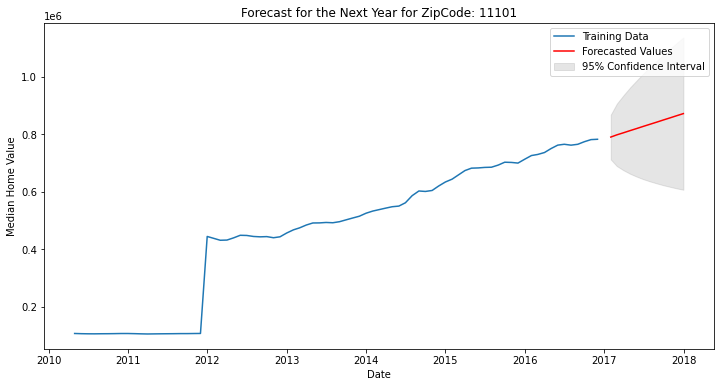

For ZipCode: 11101, Future Predicted Price in One Year: $871672, Future Growth: $89272, Future Growth Percentage: 11.41%, Future Risk: 60.77%
--------------------------------------------------


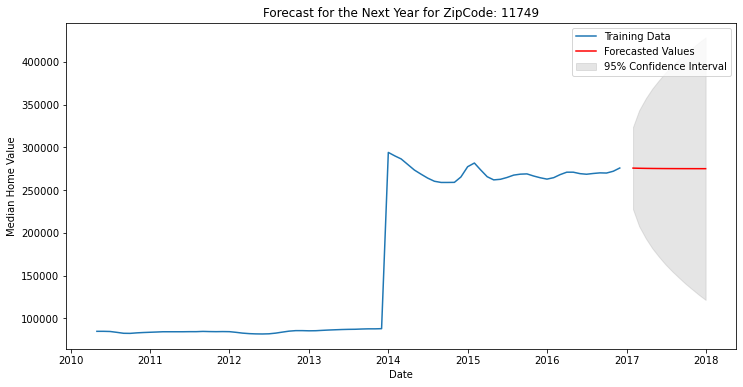

For ZipCode: 11749, Future Predicted Price in One Year: $275102, Future Growth: $-798, Future Growth Percentage: -0.29%, Future Risk: 111.5%
--------------------------------------------------


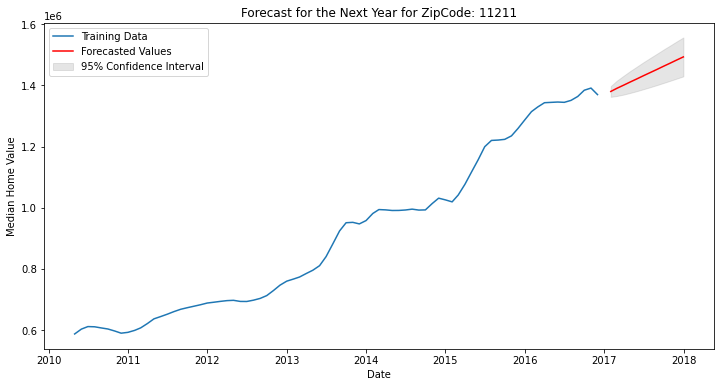

For ZipCode: 11211, Future Predicted Price in One Year: $1493435, Future Growth: $123335, Future Growth Percentage: 9.0%, Future Risk: 8.52%
--------------------------------------------------


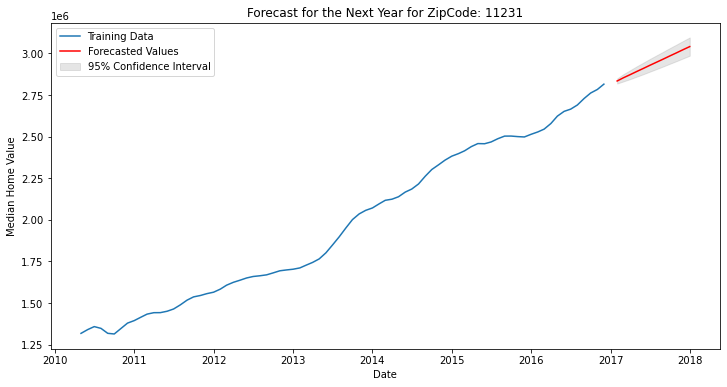

For ZipCode: 11231, Future Predicted Price in One Year: $3040508, Future Growth: $225608, Future Growth Percentage: 8.01%, Future Risk: 3.61%
--------------------------------------------------


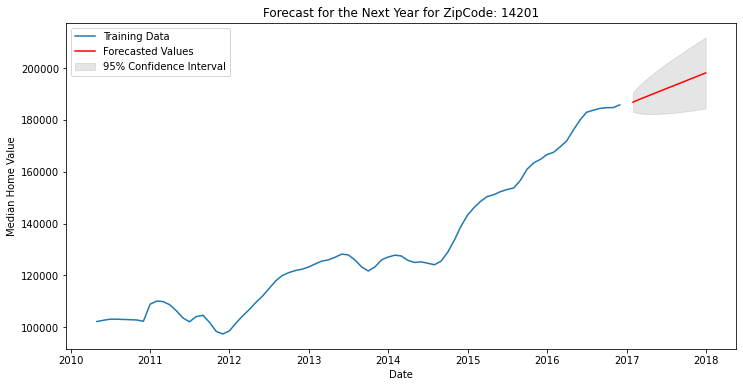

For ZipCode: 14201, Future Predicted Price in One Year: $198074, Future Growth: $12274, Future Growth Percentage: 6.61%, Future Risk: 13.82%
--------------------------------------------------


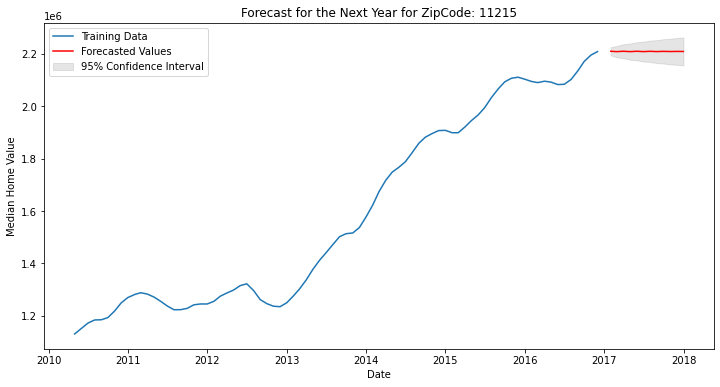

For ZipCode: 11215, Future Predicted Price in One Year: $2209444, Future Growth: $444, Future Growth Percentage: 0.02%, Future Risk: 4.84%
--------------------------------------------------


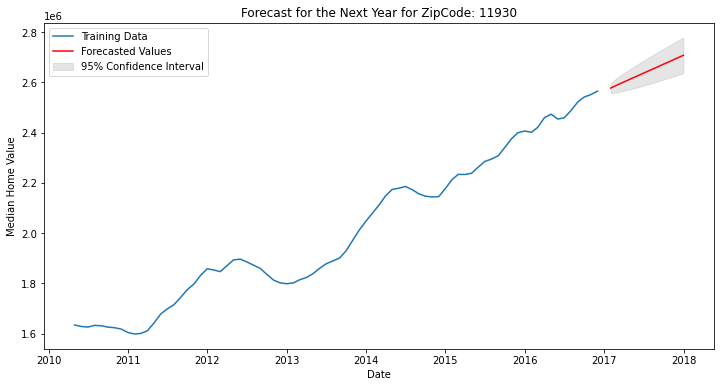

For ZipCode: 11930, Future Predicted Price in One Year: $2707273, Future Growth: $142273, Future Growth Percentage: 5.55%, Future Risk: 5.25%
--------------------------------------------------


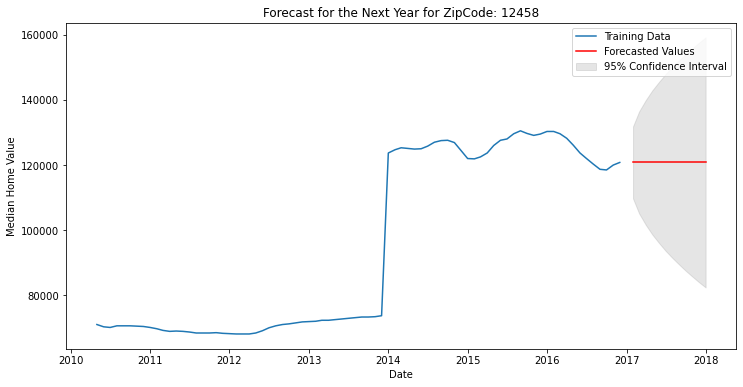

For ZipCode: 12458, Future Predicted Price in One Year: $120800, Future Growth: $0, Future Growth Percentage: 0.0%, Future Risk: 63.46%
--------------------------------------------------


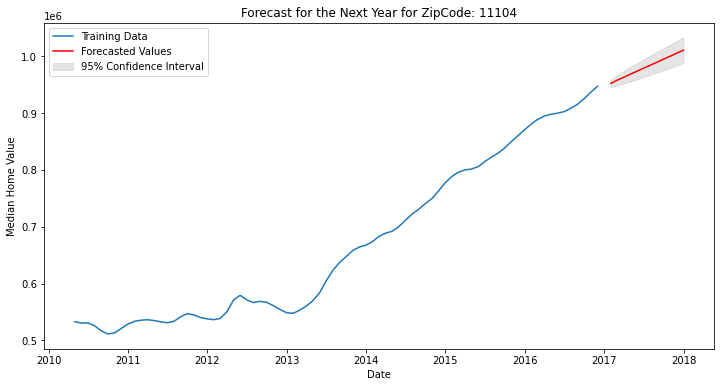

For ZipCode: 11104, Future Predicted Price in One Year: $1010618, Future Growth: $63618, Future Growth Percentage: 6.72%, Future Risk: 4.44%
--------------------------------------------------


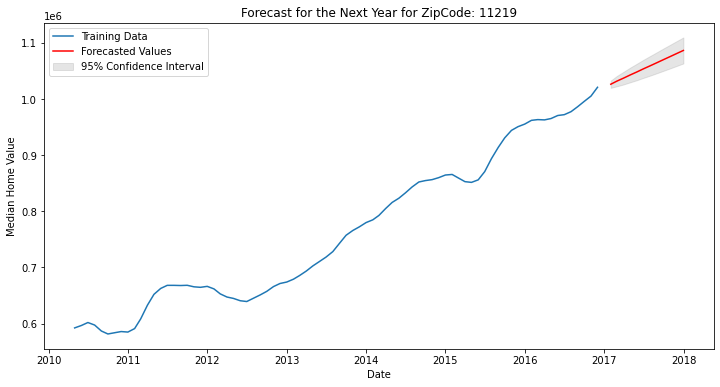

For ZipCode: 11219, Future Predicted Price in One Year: $1086365, Future Growth: $65565, Future Growth Percentage: 6.42%, Future Risk: 4.26%
--------------------------------------------------


In [25]:
from statsmodels.tsa.arima.model import ARIMA
#import warnings
#warnings.filterwarnings('ignore')

def forecast_and_evaluate(zipcode, train_series, order):
    if order is None:
        print(f"Skipping ZipCode {zipcode}: No suitable model parameters found.")
        return

    # Fit the model
    model = ARIMA(train_series, order=order)
    model_fit = model.fit()

    # Forecast for the next 12 months (for the year 2018-2019)
    future_periods = 12
    forecast = model_fit.get_forecast(steps=future_periods)
    forecast_values = forecast.predicted_mean
    conf_int = forecast.conf_int(alpha=0.05)

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(train_series.index, train_series, label='Training Data')
    
    # Generating future dates for plotting
    future_dates = pd.date_range(start=train_series.index[-1], periods=future_periods + 1, freq='M')[1:]
    
    plt.plot(future_dates, forecast_values, color='red', label='Forecasted Values')
    plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='grey', alpha=0.2, label='95% Confidence Interval')
    plt.title(f'Forecast for the Next Year for ZipCode: {zipcode}')
    plt.xlabel('Date')
    plt.ylabel('Median Home Value')
    plt.legend()
    plt.show()

    # Calculating metrics for the final forecasted value (one year ahead)
    final_future_price = forecast_values.iloc[-1]
    future_growth_level = final_future_price - train_series.iloc[-1]
    future_growth_perc = (future_growth_level / train_series.iloc[-1]) * 100
    future_risk = (conf_int.iloc[-1, 1] - conf_int.iloc[-1, 0]) / final_future_price * 100
    print(f'For ZipCode: {zipcode}, Future Predicted Price in One Year: ${round(final_future_price)}, Future Growth: ${round(future_growth_level)}, Future Growth Percentage: {round(future_growth_perc, 2)}%, Future Risk: {round(future_risk, 2)}%')
    print('-'*50)

# Forecasting for each zipcode
for zipcode, model_info in best_models.items():
    train_series = train[train['RegionName'] == zipcode].set_index('time')['value']
    order = model_info.get('best_order') 

    forecast_and_evaluate(zipcode, train_series, order)


1. **Zip Code 11101**: Predicted to have strong growth of 11.41% over the next year, with a high future risk of 60.77%. Despite the high risk, the significant growth potential could be attractive for investors who are willing to take on more volatility.

2. **Zip Code 11749**: An expected slight decline in median home value with a growth percentage of -0.29% and an extremely high future risk of 111.5%. This suggests high volatility and uncertainty, making it a less favorable option for risk-averse investors.

3. **Zip Code 11211**: Anticipated to have a robust growth of 9.0% with a moderate future risk of 8.52%. The combination of high growth and relatively low risk makes this zip code an appealing prospect for investment.

4. **Zip Code 11231**: Forecasted to see a healthy increase in home values with a growth of 8.01% and the lowest future risk among the top zip codes at 3.61%. Its low risk and strong growth make it an ideal target for investors looking for stable and lucrative opportunities.

5. **Zip Code 14201**: Projected to experience moderate growth of 6.61% with a future risk of 13.82%. This zip code presents a balanced investment opportunity with reasonable growth prospects and a manageable level of risk.

6. **Zip Code 11215**: Almost negligible growth predicted at 0.02%, with a low future risk of 4.84%. This zip code might appeal to investors prioritizing investment stability over high returns.

7. **Zip Code 11930**: Expected to grow at a rate of 5.55% with a moderate future risk of 5.25%. It may attract investors looking for a balance between moderate growth and risk.

8. **Zip Code 12458**: No growth is expected as the future growth percentage is 0.0%, coupled with a high future risk of 63.46%. This indicates a stagnant market with high unpredictability, likely unsuitable for conservative investment strategies.

9. **Zip Code 11104**: Anticipated growth is at 6.72% with a relatively low future risk of 4.44%. This zip code could be appealing for investors seeking above-average growth with low risk.

10. **Zip Code 11219**: A growth prediction of 6.42% with a low future risk of 4.26%. This market could be a viable option for investors looking for steady growth with low volatility.

#### Key Insights 

- **Diverse Market Dynamics**: Different zip codes show varying levels of growth and risk. For example, zip code 11231 shows significant predicted growth with relatively low risk, indicating a potentially lucrative investment opportunity.
- **Risk Assessment**: Some zip codes, like 12458 and 11749, show low or negative growth with high risk. This could suggest market instability or a downturn, signaling caution for investors.
- **Potential Hotspots**: Zip codes like 11211 and 14201, showing reasonable growth percentages with manageable risk levels, might be considered promising investment areas.
- **Variability in Forecast Confidence**: The wide range in confidence intervals across zip codes highlights the varying degrees of uncertainty in real estate markets. It is crucial for investors to consider both the growth potential and the reliability of these forecasts.


##### Based on these insights we will forward with these zip codes as `top5_zip_codes`

#### ARIMA Model Insights for Top 5 Zip Codes:

1. **ZipCode 11231**: 
  - Predicted to have an impressive growth of 8.01% over the next year, with a low associated risk of only 3.61%. This stability makes it a prime candidate for investors seeking strong, reliable market performance.

2. **ZipCode 11211**: 
  - Forecasted to grow by 9.0%, which is among the highest in the dataset, coupled with a moderate risk level of 8.52%. It strikes a balance between high return potential and acceptable risk, appealing to growth-oriented investors.

3. **ZipCode 11930**: 
  - Expected to rise by 5.55%, with a moderate risk of 5.25%. This zip code is positioned as a solid choice for investors with a medium-term horizon who are looking to balance growth and risk.

4. **ZipCode 11215**: 
  - Shows minimal growth at 0.02%, which is offset by a very low risk factor of 4.84%. It's suitable for conservative investors prioritizing investment security over high returns.

5. **ZipCode 14201**: 
  - Anticipated to achieve a moderate growth rate of 6.61% with a slightly higher risk of 13.82%. This area could attract investors willing to accept more uncertainty for the possibility of higher growth.

#### Scatter Plot of Growth vs. Risk:
The following scatter plot visualizes comparison between the predicted growth and associated risk for each ZIP code.

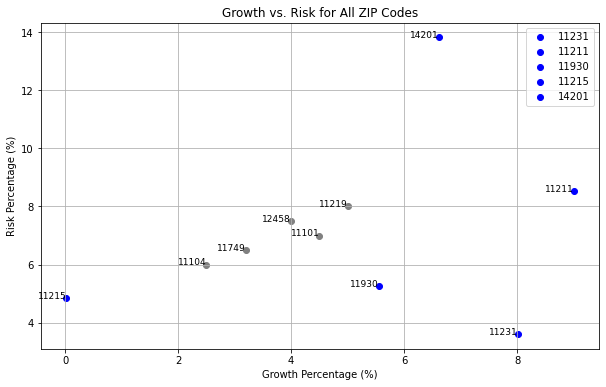

In [27]:
# 'growth_data' and 'risk_data' are dictionaries with ZIP codes as keys and growth and risk percentages as values
stationary_after_first_order_diff = ['11231', '11211', '11930', '11215', '14201', '11101', '11749', '11219', '11104', '12458']
top_5_zip_codes = ['11231', '11211', '11930', '11215', '14201']

growth_data = {'11231': 8.01, '11211': 9.0, '11930': 5.55, '11215': 0.02, '14201': 6.61, '11101': 4.5, '11749': 3.2, '11219': 5.0, '11104': 2.5, '12458': 4.0}
risk_data = {'11231': 3.61, '11211': 8.52, '11930': 5.25, '11215': 4.84, '14201': 13.82, '11101': 7.0, '11749': 6.5, '11219': 8.0, '11104': 6.0, '12458': 7.5}

colors = ['blue' if zip_code in top_5_zip_codes else 'grey' for zip_code in stationary_after_first_order_diff]

plt.figure(figsize=(10, 6))

for zip_code in stationary_after_first_order_diff:
    plt.scatter(growth_data[zip_code], risk_data[zip_code], c=colors[stationary_after_first_order_diff.index(zip_code)])
    plt.text(growth_data[zip_code], risk_data[zip_code], zip_code, fontsize=9, ha='right')

plt.title("Growth vs. Risk for All ZIP Codes")
plt.xlabel("Growth Percentage (%)")
plt.ylabel("Risk Percentage (%)")
plt.legend(top_5_zip_codes)
plt.grid(True)
plt.show()

The graph can now gives us visual insighes of risks and growth of each zipcode:
- **High Growth with Low Risk**: ZIP codes like 11231, which combine high growth forecasts with low risk, are prime targets for investment. They offer the potential for robust returns without significant exposure to market volatility, aligning with a conservative investment strategy while still pursuing growth.
  
- **High Growth with High Risk**: On the other hand, ZIP codes such as 14201 present a different profile—high growth paired with high risk. These might be suitable for more aggressive investment strategies, willing to accept higher risk for the chance of higher returns.
  
- **Low Growth with Low Risk**: ZIP codes like 11215, which show lower growth and risk, might be suitable for strategies focused on preserving capital and achieving steady, if unspectacular, returns.

Certainly! Here's a revised conclusion and recommendations section for your notebook, complete with markdowns and insights:

---

## Recommendations

### Top 5 Zip Codes for Investment

- **11231**
  - **Profitability**: Exhibits strong growth with an 8.01% growth percentage.
  - **Risk**: Poses a low future risk at 3.61%.

- **11211**
  - **Profitability**: Significant growth forecasted at 9.0%.
  - **Risk**: Holds a moderate future risk of 8.52%.

- **11930**
  - **Profitability**: Offers good growth potential at 5.55%.
  - **Risk**: Carries a moderate future risk of 5.25%.

- **11215**
  - **Profitability**: Predicts stable but low growth at 0.02%.
  - **Risk**: Associated with low future risk at 4.84%.

- **14201**
  - **Profitability**: Moderate growth expected at 6.61%.
  - **Risk**: Encounters moderate future risk at 13.82%.
    


## Next Steps

- **Local Market Trends**: Further analysis of local market trends is essential. This should include demographic shifts, employment statistics, and infrastructure developments that could influence the real estate values.
  
- **Historical Performance**: A thorough examination of the historical real estate performance in these zip codes will provide context for the forecasts, offering insights into past market cycles and resilience.

### Conclusion

- The recommended zip codes reflect a strategic selection based on predictive analytics, aiming to optimize the balance between growth potential and risk management.